## Volcanic hazards will be exacerbated by climate change–driven increase in heavy rainfall
### Jamie I. Farquharson1, Falk Amelung1
1 Rosenstiel School of Marine and Atmospheric Science, University of Miami, Miami, FL, USA

Corresponding author: james.farquharson@rsmas.miami.edu

### Import packages

In [1]:
'''
Import packages
'''
import datetime as dt
from netCDF4 import Dataset
import numpy as np
import numpy.ma as ma
import math

import fiona
import geopandas as gpd
from shapely.geometry import Point
from geopandas.geoseries import GeoSeries
from geopandas.geodataframe import GeoDataFrame

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap

import warnings
warnings.filterwarnings('ignore')

import matplotlib.font_manager as font_manager
from matplotlib import rcParams
plt.rcParams["font.family"] = 'sans-serif'

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Computer Modern Sans serif']
plt.rcParams["font.family"] = 'sans-serif'
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Palatino']
params = {'text.latex.preamble' : [r'\usepackage{amsmath}', r'\usepackage{amssymb}']}
plt.rcParams.update(params)

import random

from datetime import datetime, timedelta
import datetime as dt

import pandas as pd
import calendar

import matplotlib as matplotlib
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns

from shapely import wkt
from geopandas.tools import sjoin
import geopandas

import scipy
from scipy.stats import gaussian_kde
from scipy import sparse

from decimal import Decimal
import os
import netCDF4
from matplotlib.colors import LinearSegmentedColormap
import skimage
import glob
import string as STRING
from matplotlib import patheffects
buffer = [patheffects.withStroke(linewidth=1, foreground="w", alpha = 0.5)]
import time
import pylab

In [2]:
matplotlib.rcParams['text.usetex'] = True 
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'cm'
plt.rcParams["font.family"] = 'sans-serif'

In [3]:
filepath = '/Users/jamiefarquharson/Desktop/RSMAS/Eruption_ntbk'

In [4]:
if os.getcwd() != filepath:
    %cd $filepath

In [5]:
'''
Function converts mm input to inches (for plotting figures the correct size).
'''

def mm2inch(*tupl):
    if isinstance(tupl[0], tuple):
        return tuple(k*0.0393701 for k in tupl[0])
    else:
        return tuple(k*0.0393701 for k in tupl)
    
'''
Function realigns subplots so that the upper right corners coincide
'''

def reposition(axis1, axis2):
    plt.draw()
    p1 = axis1.get_position()
    p2 = axis2.get_position()
    axis2.set_position([p1.x1-p2.width, p1.y1-p2.height, p2.width, p2.height])

'''
Function defines factorial of value x
'''
def fact(x):
    return Decimal(math.factorial(x))

'''
Function returns max and min of a list
'''
def minmax(x):
    x = sorted(x)
    return (x[0],x[-1])

In [57]:
def call_plt_params():
    matplotlib.rcParams['text.usetex'] = True 
    matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}']
    matplotlib.rcParams['font.family'] = 'sans-serif'
    matplotlib.rcParams['font.sans-serif'] = 'cm'
    plt.rcParams["font.family"] = 'sans-serif'

In [6]:
'''
Re-orders multi-part names (for example, "Fournaise, Piton de la" becomes "Piton de la Fournaise")
'''
def string_rearranger(string):
    old_string = string
    if ', ' in old_string:
        new_string = old_string.rpartition(', ')[2] +' '+ old_string.rpartition(', ')[0]
    else:
        new_string = old_string
    return new_string

In [7]:
''' For plotting labels '''
labelArgs = {'xy': (0, 1),'xytext': (4,-4),
            'xycoords':'axes fraction',
            'textcoords':'offset points',}
labelKwargs = {
            'color':"k",
            'fontsize':12,
            'path_effects':buffer,
            'ha': 'left',
            'va': 'top',
            'zorder':np.inf}

In [8]:
'''Voice alerts'''
def speak(text):
    from IPython.display import Javascript as js, clear_output
    # Escape single quotes
    text = text.replace("'", r"\'")
    display(js(f'''
    if(window.speechSynthesis) {{
        var synth = window.speechSynthesis;
        synth.speak(new window.SpeechSynthesisUtterance('{text}'));
    }}
    '''))

Load in perceptually uniform colourmaps from http://www.fabiocrameri.ch/colourmaps.php

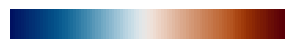

In [9]:
cm_data = np.loadtxt("climate_mods/ScientificColourMaps6/vik/vik.txt")
vik_map = LinearSegmentedColormap.from_list("vik", cm_data)
vik_map_r = LinearSegmentedColormap.from_list("vik", cm_data[::-1])
x = np.linspace(0, 100, 100)[None, :]
fig = plt.figure(1, mm2inch(90,10), dpi=100)
plt.imshow(x, aspect="auto",cmap=vik_map)
plt.axis("off")
plt.show()

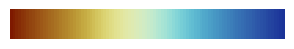

In [10]:

cm_data = np.loadtxt("climate_mods/ScientificColourMaps6/roma/roma.txt")
roma_map = LinearSegmentedColormap.from_list("roma", cm_data)
roma_map_r = LinearSegmentedColormap.from_list("roma", cm_data[::-1])
x = np.linspace(0, 10, 100)[None, :]
fig = plt.figure(1, mm2inch(90,10), dpi=100)
plt.imshow(x, aspect="auto",cmap=roma_map)
plt.axis("off")
plt.show()

In [11]:
'''Segment the "vik" colourmap'''

cmaplist = [vik_map_r(i) for i in range(vik_map_r.N)]
seg_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, vik_map_r.N)

# define the bins and normalize
bounds = np.linspace(-18, 18, 13)
norm = mpl.colors.BoundaryNorm(bounds, vik_map_r.N)


In [12]:
pla = pylab.cm.plasma
inferno = pylab.cm.inferno
def x2clr(x, total):
        return int(x/total*256-1)

### Access volcano information and pre-process

In [13]:
'''
Accesses the most recent GVP volcanoes eruptions lists, saves them as csv files: "Holocene_volcanoes" and "Holocene_eruptions".
'''
!wget --no-check-certificate --output-document Holocene_eruptions.csv "https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Eruptions&outputFormat=csv"
!wget --no-check-certificate --output-document Holocene_volcanoes.csv "https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv"

'''
Read the downloaded csv file(s) into dataframe(s)
'''
volcano_list = pd.read_csv("Holocene_volcanoes.csv")
eruption_list = pd.read_csv("Holocene_eruptions.csv")

'''
Update volcano names to avoid duplicates
'''
temp_list = list(volcano_list.Volcano_Name)
duplicate_names = list(set([x for x in temp_list if temp_list.count(x) > 1]))
duplicate_numbers = []
for j in volcano_list.index:
    if volcano_list.Volcano_Name[j] in duplicate_names:
        volcano_list.Volcano_Name[j] = volcano_list.Volcano_Name[j]+' ' + str(volcano_list.Volcano_Number[j])
        duplicate_numbers.append(volcano_list.Volcano_Number[j])
len(set(duplicate_numbers))
for j in eruption_list.index:
    if eruption_list.Volcano_Number[j] in duplicate_numbers:
        eruption_list.Volcano_Name[j] = eruption_list.Volcano_Name[j]+' ' + str(eruption_list.Volcano_Number[j])

volcanoes = list(set(eruption_list.Volcano_Name)) ## {
print('{} volcano entries found, with a total of {} eruptions.\n{} distinct volcanoes identified.\n{} duplicate names:\n{}'.format(
    len(volcano_list),len(eruption_list),len(volcanoes), len(duplicate_names), duplicate_names))                           

--2021-01-22 12:11:45--  https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Eruptions&outputFormat=csv
Resolving webservices.volcano.si.edu (webservices.volcano.si.edu)... 160.111.244.27
Connecting to webservices.volcano.si.edu (webservices.volcano.si.edu)|160.111.244.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Holocene_eruptions.csv’

Holocene_eruptions.     [             <=>    ]   2.02M   458KB/s    in 4.7s    

2021-01-22 12:11:51 (441 KB/s) - ‘Holocene_eruptions.csv’ saved [2115168]

--2021-01-22 12:11:51--  https://webservices.volcano.si.edu/geoserver/GVP-VOTW/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=GVP_VOTW:Smithsonian_VOTW_Holocene_Volcanoes&outputFormat=csv
Resolving webservices.volcano.si.edu (webservices.volcano.si.edu)... 160.111.244.27
Connecting to webservices.volcano.si.edu (webservices.volca

In [21]:
'''
Extracts latitude and longitude data for each volcano in 'volcano_list' [formatted in the dataframe as 'POINT (x.xx x.xxx)'] (WKT format?).
Updates dataframe with extracted coordinates.
'''

lons = []
lats = []
for j,k in enumerate(volcano_list.GeoLocation):
    lons.append(float(k[7:-1].split()[0])) # Extracts longitude as string, converts to float
    lats.append(float(k[7:-1].split()[1])) # Extracts latitude as string, converts to float
volcano_list['lats'] = lats # Adds latitudes to original dataframe
volcano_list['lons'] = lons # Advods longitudes to original dataframe

import fnmatch
lst = list(set(volcano_list.Primary_Volcano_Type))
filtered = fnmatch.filter(lst, 'Sub*')
volcano_list = volcano_list.loc[~volcano_list["Primary_Volcano_Type"].isin(filtered)]
print('Done\nand')

'''
Coordinates ready for plotting
'''
locations = volcano_list[['lats', 'lons']]
locations["name"] = volcano_list.Volcano_Name
locations["number"] = volcano_list.Volcano_Number
locationlist = locations.values.tolist
print('Done')

Done
and
Done


In [22]:
'''
Creates dataframe with eruption information for all active volcanoes
'''
volcano_countries = volcano_list.set_index('Volcano_Number')
all_active_volcanoes = pd.merge(eruption_list,volcano_countries, how = 'inner', on = ['Volcano_Name'])

In [23]:
'''
Dataframe contains Name, lat, and lon of each eruptive volcano
'''

all_volcano_set_name = []
all_volcano_set_lat = []
all_volcano_set_lon = []
all_volcano_set_point = []

for j, k in enumerate(all_active_volcanoes.Volcano_Name):
    if k not in all_volcano_set_name:
        all_volcano_set_name.append(k)
        all_volcano_set_lat.append(all_active_volcanoes.lats[j])
        all_volcano_set_lon.append(all_active_volcanoes.lons[j])
        all_volcano_set_point.append(all_active_volcanoes.GeoLocation_y[j])
        

all_volcano_set = pd.DataFrame({'Name' :all_volcano_set_name,'lat' : all_volcano_set_lat, 'lon' : all_volcano_set_lon, 'point' : all_volcano_set_point})
all_volcano_set.set_index('Name', inplace = True)
print('{} discrete volcanoes in unfiltered dataset'.format(len(all_volcano_set)))

830 discrete volcanoes in unfiltered dataset


In [24]:
'''
Dataframe contains Name, lat, and lon of each eruptive volcano
'''

volcano_set_name = []
volcano_set_lat = []
volcano_set_lon = []

for j, k in enumerate(all_active_volcanoes.Volcano_Name):
    if k not in volcano_set_name:
        volcano_set_name.append(k)
        volcano_set_lat.append(all_active_volcanoes.lats[j])
        volcano_set_lon.append(all_active_volcanoes.lons[j])

volcano_set = pd.DataFrame({'Name' :volcano_set_name,'lat' : volcano_set_lat, 'lon' : volcano_set_lon})
volcano_set.set_index('Name', inplace = True)

### Functions for reading and processing climate data

In [25]:
''' Models used '''
fileNameCodes = [['NorESM1-M',
  'CSIRO-Mk3-6-0',
  'MRI-CGCM3',
  'ACCESS1-3',
  'inmcm4',
  'MIROC5',
  'IPSL-CM5A-MR',
  'CanESM2',
  'CNRM-CM5']]

In [26]:
def list_of_models(parameter = "pr", modelName =""):
    import glob as glob
    models = [mod for mod in glob.glob("climate_mods/{}*".format(parameter))]
    modelList = []
    for modelString in models:
        if modelName in modelString:
            modelList.append(modelString)
    return sorted(modelList)

In [27]:
'''https://stackoverflow.com/a/3431835/11191589''' ## Need to include hash list
import hashlib
def hash_bytestr_iter(bytesiter, hasher, ashexstr=False):
    for block in bytesiter:
        hasher.update(block)
    return hasher.hexdigest() if ashexstr else hasher.digest()

def file_as_blockiter(afile, blocksize=65536):
    with afile:
        block = afile.read(blocksize)
        while len(block) > 0:
            yield block
            block = afile.read(blocksize)

def checksum(parameter="pr", modelName=""):
    fnamelst = list_of_models(parameter=parameter, modelName=modelName)
    return [(fname, hash_bytestr_iter(file_as_blockiter(open(fname, 'rb')), hashlib.md5()))
    for fname in fnamelst]

In [28]:
for i in range(9):
    checkSum = checksum(parameter="pr", modelName=fileNameCodes[0][i])
    print(checkSum[0][1])
# checkdict

b'\x8b)\xb5\xaeh<\x1dg\xc9C\x98\x06\xbf\xde\x9c\xeb'
b'\x87\xf2\x16\xabU\xa1\xab\x88!BQt\xcd\xcc\xd2\xbd'
b'.\x99y\x97\xe2\xa1\x9c\xf5\xe1B\xdf\xbd\x1b\xbb\xe3l'
b'\xe4\xb3\x15G\xa3m\x10\x8a\x08\xecv\xa9\x80\x8a\xd5K'
b'\xbb\xb0\x19r\x15\x9dx/O\xe7\xc7\xf2\xff\xd2\xda\xca'
b'\xdd[\x8e\x8d\x93\xf4-~3\xca3)\x88x\xb6y'
b"\xe3\x1c\xabI\xf6=9I\x89'4I\xaa\x1coe"
b'{\x05\x0b&\xb2\xd6\x9d:\x01\xf3\xd2\x8eu\xb6"5'
b'*\xc0ZM\xe4\x83\x18\x9b\xb1+\x05\x02\xb4\x01\x0b\x8a'


In [30]:
def model_info(parameter="pr", modelName="", checkSum=False):
    import netCDF4
    import hashlib
    try:
        modelFile = netCDF4.MFDataset(list_of_models(parameter=parameter, modelName=modelName))
        if checkSum == False:
            print('model: {}; var: {}; (time,lat,lon) : {}; (la,lo) : {:.1f} {:.1f}'.format(
        modelFile.__dict__['model_id'],
        modelFile.variables[parameter].long_name,
        modelFile.variables[parameter].shape,
        modelFile.variables['lat'][0],
        modelFile.variables['lon'][0]
    ))
            modelFile.close()
        else:
            checksum = checksum(parameter=parameter, modelName=modelName)
            print(checksum)

# print(file_hash.digest())
# print(file_hash.hexdigest())  # to get a printable str instead of bytes
    except:
        print("Error reading {}".format(modelName)) ## checksum here

In [31]:
def model_lalo(parameter="pr", modelName=""):
    import netCDF4
    try:
        modelFile = netCDF4.MFDataset(list_of_models(parameter=parameter, modelName=modelName))
#         print("ok")
        return modelFile.variables["lat"][:], modelFile.variables["lon"][:]
    except:
        print("Error reading {}".format(modelName))

In [32]:
def volcano_ij(volcano, lats, lons, verbose = False):
    volcano = volcano
    lon_vals = lons
    lat_vals = lats
    try:
        name_volc = volcano
        lat_volc = volcano_set.loc[[name_volc]].lat.values[0]
        lon_volc = volcano_set.loc[[name_volc]].lon.values[0]+180

        '''
        Data are not infinite, so these lambda functions determine the latitude and longitute in the NCDF4 file(s) that
        are *closest* to the precise coordinates of a given volcano. Volcano coordinates are defined above (lat_volc, lon_volc),
        and typically correspond to the summit or centre of the caldera region.
        '''
        j_volc = min(lon_vals, key=lambda x:abs(x-lon_volc))
        i_volc = min(lat_vals, key=lambda x:abs(x-lat_volc))
        if verbose == True:
            print("({:.1f},{:.1f}) --> ({:.1f},{:.1f})".format(
            lat_volc,lon_volc, i_volc, j_volc))
        return i_volc, j_volc
    except:
        print("Problem with {}".format(string_rearranger(volcano)))
  

In [72]:
def volcano_list_ij(volcanoList, lats, lons, verbose = False):
#     volcano = volcano
    volcanoList = volcanoList
  
    lon_vals = lons
    lat_vals = lats
    tup_list = []

    try:
        for volcano in volcanoList:
            name_volc = volcano
            lat_volc = volcano_list[volcano_list["Volcano_Name"] == volcano].lats.values[0]
            lon_volc = volcano_list[volcano_list["Volcano_Name"] == volcano].lons.values[0]+180

            '''
            Data are not infinite, so these lambda functions determine the latitude and longitute in the NCDF4 file(s) that
            are *closest* to the precise coordinates of a given volcano. Volcano coordinates are defined above (lat_volc, lon_volc),
            and typically correspond to the summit or centre of the caldera region.
            '''
            j_volc = min(lon_vals, key=lambda x:abs(x-lon_volc))
#             print("ok to here 3")
            i_volc = min(lat_vals, key=lambda x:abs(x-lat_volc))
#             print("ok to here 4")
            if verbose == True:
                print("({:.1f},{:.1f}) --> ({:.1f},{:.1f})".format(
                lat_volc,lon_volc, i_volc, j_volc))
            tup_list.append((i_volc, j_volc))
        return list(set(tup_list))
    except:
        print("Problem with {}".format(string_rearranger(volcano)))
#         continue

#### Sanity check 

In [33]:
''' Convert geolocation to model-specific (i,j) coordinates''' 
lat, lon = model_lalo(parameter="pr", modelName=fileNameCodes[0][1])
volcano_ij(volcano = "St. Helens", lats = lat, lons = lon)

(45.698692321777344, 58.125)

In [34]:
def global_mean_temp(modelName, method = "max", verbose = False):
    ''' "how" can be either "max" or "mean" '''
    import netCDF4
    import pandas as pd
    try:
        modelFile = netCDF4.MFDataset(list_of_models(parameter="ta", modelName=modelName))
#         print("imported")
        startString = modelFile.variables["time"].units.split()[2] # Days since XXX date
        start = datetime.strptime(startString, "%Y-%m-%d")
        time = [start+timedelta(int(x)) for x in modelFile.variables["time"][:]]
        model_gmT = []
#         print("ok")
        for x in range(modelFile.variables["ta"].shape[0]):
            model_gmT.append(np.nanmean(modelFile.variables["ta"][x][0]))
        gmT_df = pd.DataFrame(
    {'ix':time,'date':time, ##
     'temp': model_gmT
    })
        gmT_df=gmT_df.set_index('ix')
        gmT_df.index = pd.to_datetime(gmT_df.index)
        gmT = gmT_df.resample("Y", how=method)
#         gmT_av = gmT_df.resample("Y", how='mean')

        modelFile.close()
        if verbose == True:
            print("{} succesfully processed".format(modelName))
        return gmT, gmT_df
    except:
        print("Error reading {}".format(modelName))

def heavy_rainfall(i_volc, j_volc, modelName="", method = "max", verbose = False):
    ''' "how" can be either "max" or "mean" '''
    import netCDF4
    import pandas as pd
    try:
        modelFile = netCDF4.MFDataset(list_of_models(parameter="pr", modelName=modelName))
        startString = modelFile.variables["time"].units.split()[2] # Days since XXX date
        start = datetime.strptime(startString, "%Y-%m-%d")
        time = [start+timedelta(int(x)) for x in modelFile.variables["time"][:]]
        rx_volc = []
        lat_vals = modelFile.variables["lat"][:]
        lon_vals = modelFile.variables["lon"][:]
#         print("ok to here1")
        i = int(np.where(lat_vals==i_volc)[0])
#         print("ok to here2")
        j = int(np.where(lon_vals==j_volc)[0])
#         print("ok to here3")
        prcp = list(modelFile.variables["pr"][:,i,j])
        temp_df = pd.DataFrame(
    {'ix':time,'date':time, ##
     'rainfall': prcp
    })
        temp_df=temp_df.set_index('ix')
        temp_df.index = pd.to_datetime(temp_df.index)
        RX1 = temp_df.resample("Y", how=method)
#         RX1_av = temp_df.resample("Y", how='mean')
#         m, c, r, p, s = linregress(gmT,temp_df.rainfall)  ### call in gmT?
#         rx_volc.append((m*2100+c)/(m*2006+c))

        modelFile.close()
        if verbose == True:
            print("{} succesfully processed".format(modelName))
        return temp_df, RX1
    except:
        print("Error reading {}".format(modelName))
        


In [67]:
def heavy_rainfall_area(listOfVolcanoes, modelName="", method = "max", verbose = False):
    ''' "how" can be either "max" or "mean" '''
    try:
        modelFile = netCDF4.MFDataset(list_of_models(parameter="pr", modelName=modelName))
        startString = modelFile.variables["time"].units.split()[2] # Days since XXX date
        start = datetime.strptime(startString, "%Y-%m-%d")
        time = [start+timedelta(int(x)) for x in modelFile.variables["time"][:]]

        
        lat_vals = modelFile.variables["lat"][:]
        lon_vals = modelFile.variables["lon"][:]
        tup_list = volcano_list_ij(volcanoList=listOfVolcanoes, lats=lat_vals, lons=lon_vals)
#         print("fine)")
        lat_array = [int(np.where(lat_vals == x[0])[0]) for x in tup_list]
        lon_array = [int(np.where(lon_vals == x[1])[0]) for x in tup_list]
        av_areal_prcp = [modelFile.variables["pr"][i][(lat_array,lon_array)].mean() \
                 for i in range(len(modelFile.variables["time"]))]
        temp_df = pd.DataFrame(
    {'ix':time,'date':time, ##
     'rainfall': av_areal_prcp
    })
        temp_df=temp_df.set_index('ix')
        temp_df.index = pd.to_datetime(temp_df.index)
        RX = temp_df.resample("Y", how=method)


        modelFile.close()
        if verbose == True:
            print("{} succesfully processed".format(modelName))
        return temp_df, RX
    except:
        print("Error reading {}".format(modelName))
#         print(self.__name__)

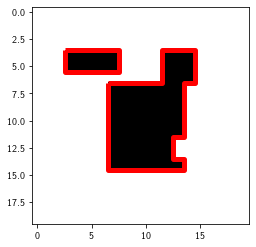

In [35]:
def get_all_boundary_edges(bool_img):
    """
    Get a list of all edges
    (where the value changes from 'True' to 'False') in the 2D image.
    Return the list as indices of the image.
    """
    ij_boundary = []
    ii, jj = np.nonzero(bool_img)
    for i, j in zip(ii, jj):
        # North
        if j == bool_img.shape[1]-1 or not bool_img[i, j+1]:
            ij_boundary.append(np.array([[i, j+1],
                                         [i+1, j+1]]))
        # East
        if i == bool_img.shape[0]-1 or not bool_img[i+1, j]:
            ij_boundary.append(np.array([[i+1, j],
                                         [i+1, j+1]]))
        # South
        if j == 0 or not bool_img[i, j-1]:
            ij_boundary.append(np.array([[i, j],
                                         [i+1, j]]))
        # West
        if i == 0 or not bool_img[i-1, j]:
            ij_boundary.append(np.array([[i, j],
                                         [i, j+1]]))
    if not ij_boundary:
        return np.zeros((0, 2, 2))
    else:
        return np.array(ij_boundary)

def close_loop_boundary_edges(xy_boundary, clean=True):
    """
    Connect all edges defined by 'xy_boundary' to closed 
    boundary lines.
    If not all edges are part of one surface return a list of closed 
    boundaries is returned (one for every object).
    """

    boundary_loop_list = []
    while xy_boundary.size != 0:
        # Current loop
        xy_cl = [xy_boundary[0, 0], xy_boundary[0, 1]]  # Start with first edge
        xy_boundary = np.delete(xy_boundary, 0, axis=0)

        while xy_boundary.size != 0:
            # Get next boundary edge (edge with common node)
            ij = np.nonzero((xy_boundary == xy_cl[-1]).all(axis=2))
            if ij[0].size > 0:
                i = ij[0][0]
                j = ij[1][0]
            else:
                xy_cl.append(xy_cl[0])
                break

            xy_cl.append(xy_boundary[i, (j + 1) % 2, :])
            xy_boundary = np.delete(xy_boundary, i, axis=0)

        xy_cl = np.array(xy_cl)

        boundary_loop_list.append(xy_cl)

    return boundary_loop_list

def plot_world_outlines(bool_img, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    ij_boundary = get_all_boundary_edges(bool_img=bool_img)
    xy_boundary = ij_boundary - 0.5
    xy_boundary = close_loop_boundary_edges(xy_boundary=xy_boundary)
    cl = LineCollection(xy_boundary, **kwargs)
    ax.add_collection(cl)


array = np.zeros((20, 20))
array[4:6, 3:8] = 1
array[4:7, 12:15] = 1
array[7:15, 7:14] = 1
array[12:14, 13:14] = 0

plt.figure()
plt.imshow(array, cmap='binary')
plot_world_outlines(array.T, lw=5, color='r')

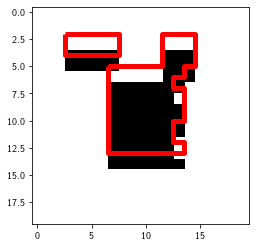

In [36]:
def plot_world_outlines_(bool_img, ax=None, offs=[.5,.5],**kwargs):
    if ax is None:
        ax = plt.gca()
    else:
        ax = ax
    offs = offs
    ij_boundary = get_all_boundary_edges(bool_img=bool_img)
    xy_boundary = ij_boundary - offs
    xy_boundary = close_loop_boundary_edges(xy_boundary=xy_boundary)
    cl = LineCollection(xy_boundary,**kwargs)
#     cl.set_offsets( (0., 1))
    ax.add_collection(cl)


array = np.zeros((20, 20))
array[4:6, 3:8] = 1
array[4:7, 12:15] = 1
array[7:15, 7:14] = 1
array[12:14, 13:14] = 0
array[8:9, 13:14] = 0


plt.figure()
plt.imshow(array, cmap='binary')
plot_world_outlines_(array.T,ax=None,offs = (.5,2.), lw=5, color='r')

In [288]:
# def plot_FMR_globe(axis):

#     ax1 = axis
#     ax1.coastlines(resolution='50m', color='w', linewidth=1, zorder = 9)
#     ax1.coastlines(resolution='50m', color='k', linewidth=0.5, zorder = 9)
#     im =ax1.pcolormesh(
#         rs_lons, rs_lats, model_mean,
#         cmap=vik_map_r,
#                    transform = ccrs.PlateCarree(),vmin = -18, vmax=18)

    
#     blank = ma.masked_where(matched_array == 1, matched_array)
#     ax1.contourf(rs_lons, rs_lats, blank,
#                  hatches =[20*'.',None], alpha=0.,transform = ccrs.PlateCarree()) #20*'.'

#     plot_world_outlines_(C.T,offs=(0,90.5),ax = axis,lw=.25, color='k',transform = ccrs.PlateCarree())

#     cbar = plt.colorbar(im,orientation='horizontal', extend = "both", shrink = 0.8, ticks = [-15, -10, -5, 0, 5, 10, 15])
#     cbar.ax.set_ylabel(r"Forced model response (2005, 2100] [\% K$^{-1}$]", rotation=0, fontsize = "small")
#     cbar.ax.yaxis.set_label_coords(0.5,1.5)
#     cbar.ax.tick_params(labelsize="small", direction = "in", length = 2.5)
#     cbar.ax.xaxis.set_ticks_position('both')
#     ax1.outline_patch.set_linewidth(0.5)


### Forced model response has been calculated for each model and is accessible as numpy arrays

In [38]:
ls data/*fmr.npy

data/ACCESS1.3_fmr.npy      data/MIROC5_fmr.npy
data/CNRM-CM5_fmr.npy       data/MRI-CGCM3_fmr.npy
data/CSIRO-Mk3-6-0_fmr.npy  data/NorESM1-ME_fmr.npy
data/CanESM2_fmr.npy        data/inmcm4_fmr.npy
data/IPSL-CM5A-MR_fmr.npy


In [39]:
'''
Import forced model response data for different GCMs.
Binarize data in terms of whether there is a projected increase or decrease in heavy precipitation per degree warming.
Resize arrays onto a common grid (180 x 360). Performs quick sanity check at end.
'''
 
fmr_arrays = glob.glob("data/*fmr.npy")

boolean_arrays = np.empty(shape=(180,360,len(fmr_arrays)))

for ix, model in enumerate(fmr_arrays):

    boolean_arrays[:,:,ix] = (
        skimage.transform.resize(           # resize all arrays onto a common grid
        np.where(np.load(model)>0, 1,0.),  # binarize model data {-1|1}
        (180,360),                          # size of new grid
        order = 0)                          # Nearest neighbour interpolation
        ).astype(int)                       # Convert dtype using astype
    
for x in range(len(fmr_arrays)):
    print("Everything looks good here" if set(np.ravel(boolean_arrays[:,:,x])) == {1.0, 0.0} else "Problem here") # Sanity check

Everything looks good here
Everything looks good here
Everything looks good here
Everything looks good here
Everything looks good here
Everything looks good here
Everything looks good here
Everything looks good here
Everything looks good here


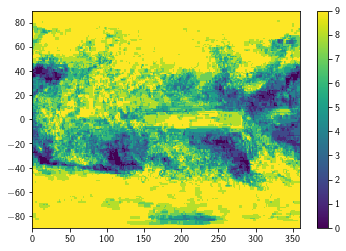

In [40]:
''' Add values of all arrays '''
sum_array = abs(np.sum(boolean_arrays, axis = 2))
rs_lats = np.linspace(-90,90,180)
rs_lons = np.linspace(0, 360, 360)
plt.pcolormesh(rs_lons, rs_lats, sum_array)
plt.colorbar()
plt.show()

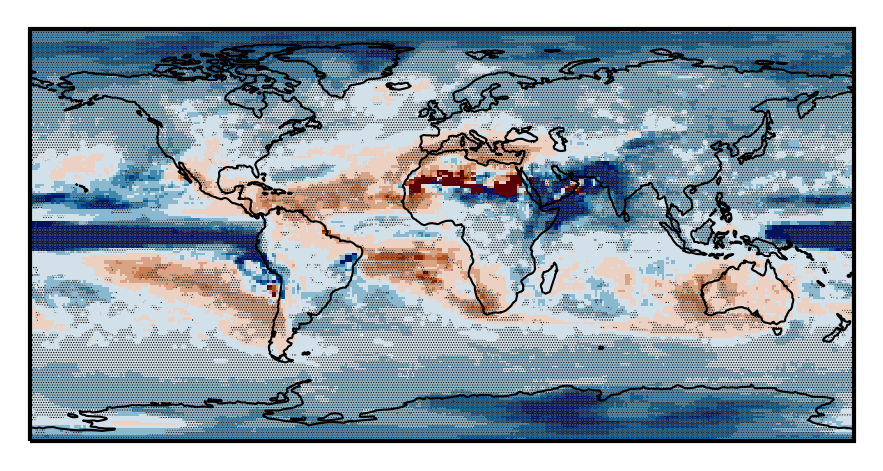

In [41]:
resized_arrays = np.empty(shape=(180,360,len(fmr_arrays)))

for ix, model in enumerate(fmr_arrays):
    a = np.load(model)
    resized_arrays[:,:,ix] = (skimage.transform.resize(a, (180,360), order = 0)).astype(int)
model_mean = np.mean(resized_arrays, axis = 2)

''' Grid  cells where 7 or more models agree '''
matched_array = np.where(abs(sum_array-4.5)>2, 1,0)

fig = plt.figure(1, figsize=(mm2inch(90,90)), frameon=True, dpi=300)
ax1 = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax1.coastlines(resolution='110m', color='k', linewidth=0.5, zorder = 9)

plt.pcolormesh(
    rs_lons, rs_lats, model_mean,
    cmap = seg_cmap, norm=norm,
               transform = ccrs.PlateCarree(),vmin = -18, vmax=18)

plt.rcParams['hatch.color'] ="w"
plt.rcParams['hatch.linewidth'] = 0.5
C = ma.masked_where(matched_array == 0, matched_array)
plt.contourf(rs_lons, rs_lats, C,
             hatches =[20*'.',None], alpha=0.,transform = ccrs.PlateCarree())
plt.rcParams['hatch.color'] ="k"
plt.rcParams['hatch.linewidth'] = 0.2
plt.contourf(rs_lons, rs_lats, C,
             hatches =[20*'.',None], alpha=0.,transform = ccrs.PlateCarree())
plt.show()
speak("Resized arrays plotted")

In [42]:
''' lat/lon points where models agree '''
stipple_points = []
for i, lat in enumerate(rs_lats):
    for j, lon in enumerate(rs_lons[:-1]):
        if matched_array[i,j] == 1:
            stipple_points.append(tuple([lon, lat]))

In [43]:
''' colours for matching points '''
stipple_colors = []
for i, lat in enumerate(rs_lats):
    for j, lon in enumerate(rs_lons[:-1]):
        if matched_array[i,j] == 1:
            if model_mean[i,j] >= 0:
                stipple_colors.append(vik_map_r(255))
            else:
                stipple_colors.append(vik_map_r(0))

In [44]:
''' Print percentage agreement beween models '''
size = 1
for dim in np.shape(matched_array): size *= dim
print("Global FMR sign agreement (7/9 models): {:.2f} %".format(len(stipple_points)/size*100))

Global FMR sign agreement (7/9 models): 73.45 %


In [45]:
''' Create list of longitudes offset by 180 degrees '''
lons_360 = []
for lon in locations.lons:
    if lon <0:
        lons_360.append(360+lon)
    else:
        lons_360.append(lon)

In [46]:
''' relocate volcanoes acccording to offset '''
relocated = []
i_reloc =[]
j_reloc =[]

for i, lat in enumerate(locations.lats):
    i_reloc.append(min(rs_lats, key=lambda x:abs(x-lat)))  
for j, lon in enumerate(lons_360):
    j_reloc.append(min(rs_lons, key=lambda x:abs(x-lon)))
relocated= list(zip(j_reloc, i_reloc))
assert len(locations) == len(relocated)

### Determine how many volcanoes rainfall will increase, decrcease, or if there is insufficient model agreement

In [47]:
volcano_colors = []
volc_wetter = 0
volc_drier = 0
volc_ambig = 0
fmr_val = []
fmr = []
for tup in relocated:
    i = list(rs_lats).index(tup[1])
    j = list(rs_lons).index(tup[0])
    fmr_val.append(model_mean[i,j])
    if matched_array[i,j] == 1:
        if model_mean[i,j] >= 0:
            volcano_colors.append(vik_map_r(255))
            volc_wetter+=1
            fmr.append('pos')
        else:
            volcano_colors.append(vik_map_r(0))
            volc_drier+=1
            fmr.append('neg')
    else:
        volcano_colors.append("grey")
        volc_ambig+=1
        fmr.append('amb')
# print(len(volcano_colors))
print("wetter: {} ({:.0f} %); drier: {} ({:.0f} %); ambiguous {} ({:.0f} %)".format(volc_wetter, 
                                                                                    (volc_wetter/len(volcano_colors))*100,
                                                                                    volc_drier,
                                                                                    (volc_drier/len(volcano_colors))*100,
                                                                                    volc_ambig,
                                                                                   (volc_ambig/len(volcano_colors))*100,))
print("{} volcanoes".format(sum([volc_wetter, volc_drier, volc_ambig])))

wetter: 768 (59 %); drier: 112 (9 %); ambiguous 415 (32 %)
1295 volcanoes


In [48]:
'''Update locations dataframe'''
locations["relocated"] = relocated
locations["FMR"] = fmr
locations["FMR_val"] = fmr_val
locations.head()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

,lats,lons,name,number,relocated,FMR,FMR_val
0,50.170,6.85,West Eifel Volcanic Field,210010,"(7.0194986072423395, 49.776536312849174)",pos,3.555556
1,45.775,2.97,Chaine des Puys,210020,"(3.0083565459610027, 45.75418994413408)",pos,1.666667
2,42.170,2.53,Olot Volcanic Field,210030,"(3.0083565459610027, 41.73184357541899)",neg,-2.444444
3,38.870,-4.02,Calatrava Volcanic Field,210040,"(355.98885793871864, 38.71508379888269)",neg,-5.000000
4,42.600,11.93,Vulsini,211003,"(12.03342618384401, 42.73743016759778)",neg,-1.666667


In [49]:
'''
Top n volcanoes sorted by FMR value (values above 0 only)
'''
n = 5
locations[locations.FMR=="pos"].nlargest(n, "FMR_val")

,lats,lons,name,number,relocated,FMR,FMR_val
154,19.80,18.53,"Koussi, Emi",225021,"(18.050139275766014, 19.608938547486034)",pos,16787.888889
153,21.03,16.45,"Tousside, Tarso",225010,"(16.044568245125348, 20.614525139664806)",pos,975.333333
155,20.92,17.28,"Voon, Tarso",225020,"(17.04735376044568, 20.614525139664806)",pos,970.444444
1153,-0.88,-89.50,San Cristobal 353120,353120,"(270.7520891364902, -0.5027932960893793)",pos,46.000000
169,23.08,39.78,"Rahat, Harrat",231070,"(40.11142061281337, 22.625698324022352)",pos,45.111111


In [50]:
'''
Separate volcanoes according to their forced model response
'''
fmr_pos = locations[locations["FMR"] == "pos"].name.reset_index()
fmr_neg = locations[locations["FMR"] == "neg"].name.reset_index()
fmr_amb = locations[locations["FMR"] == "amb"].name.reset_index()
fmr_pos.head()

,index,name
0,0,West Eifel Volcanic Field
1,1,Chaine des Puys
2,40,"Tair, Jebel at"
3,41,Zukur
4,42,Hanish


In [51]:
matplotlib.rcParams['text.usetex'] = True 
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'cm'
plt.rcParams["font.family"] = 'sans-serif'

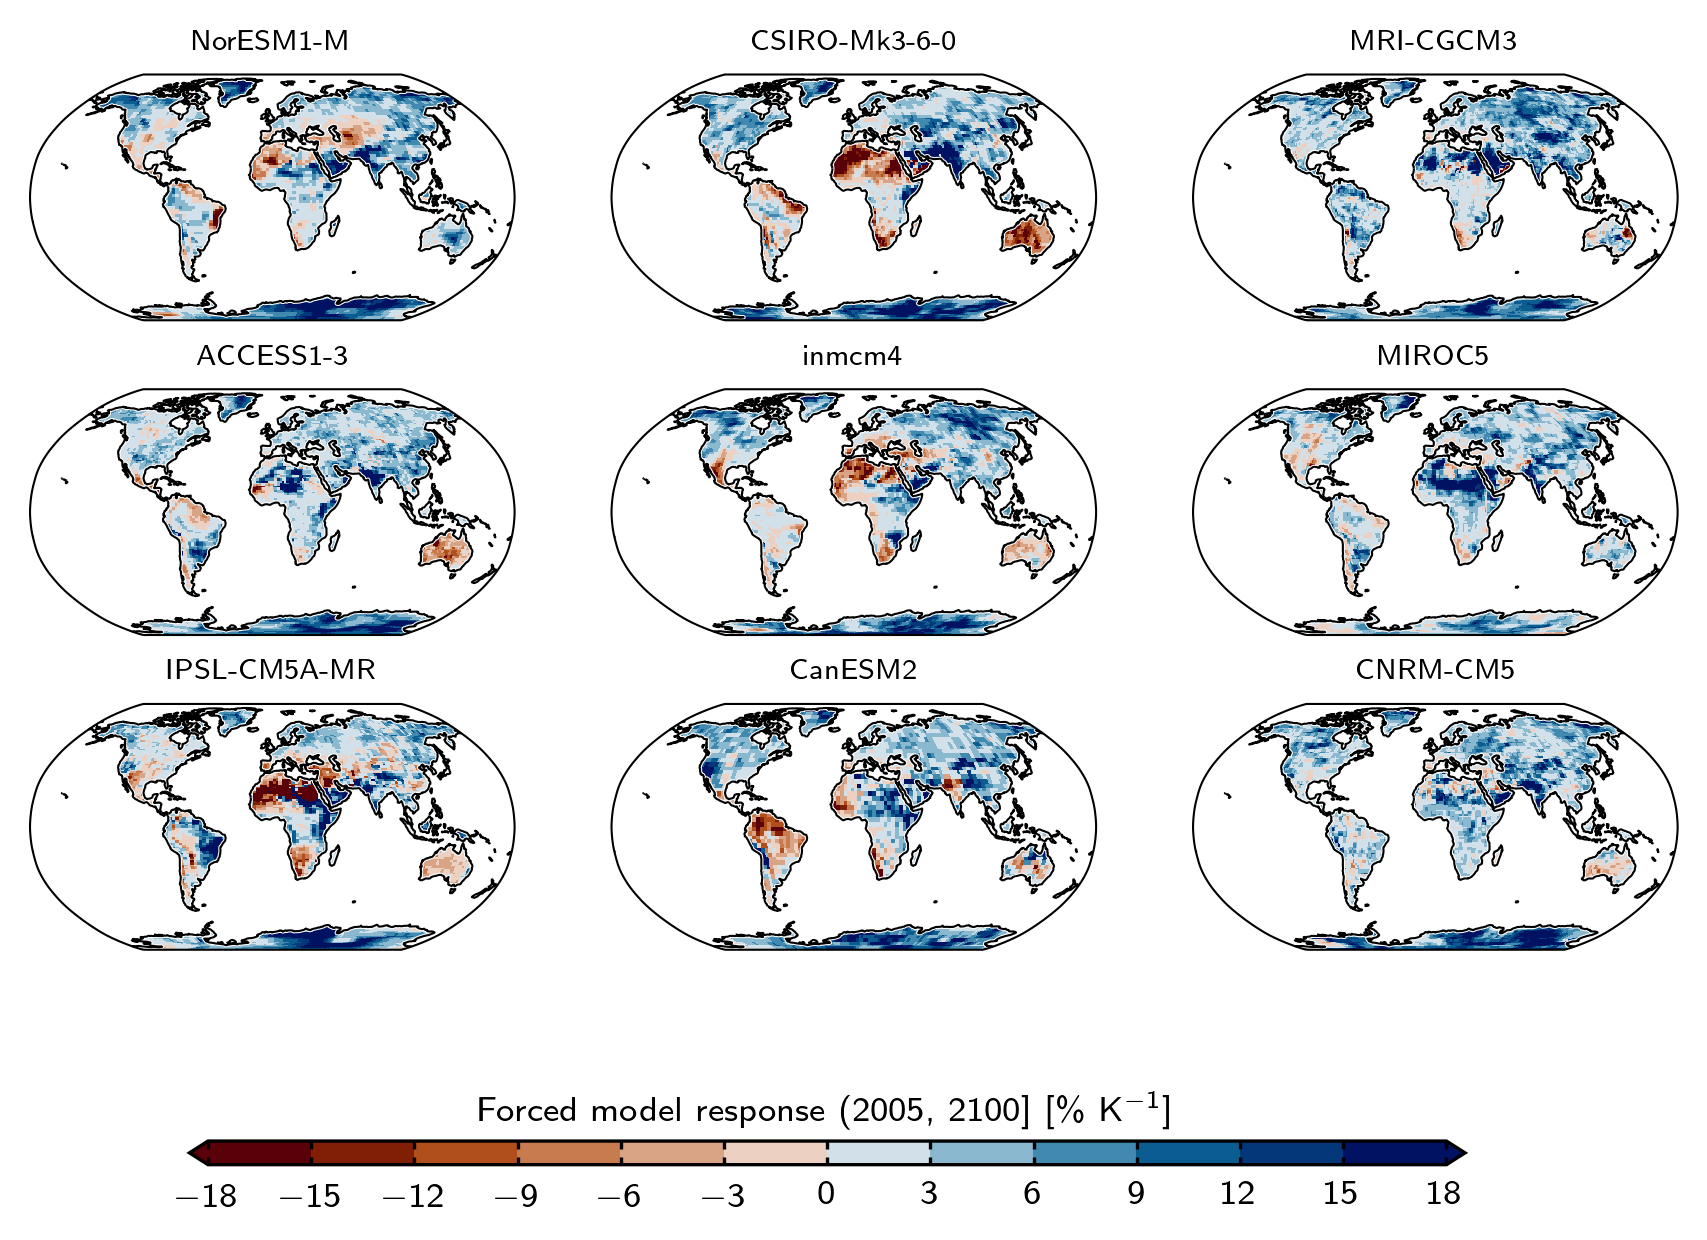

<IPython.core.display.Javascript object>

In [52]:

fig = plt.figure(1, figsize=(mm2inch(180,100)), frameon=True, dpi=300)
gs = plt.GridSpec(3, 3, figure=fig, wspace=0, hspace=0
                 )

axs = [fig.add_subplot((gs[0,0])),
       fig.add_subplot((gs[0,1])),
       fig.add_subplot((gs[0,2])),
       fig.add_subplot((gs[1,0])),
       fig.add_subplot((gs[1,1])),
       fig.add_subplot((gs[1,2])),
       fig.add_subplot((gs[2,0])),
       fig.add_subplot((gs[2,1])),
       fig.add_subplot((gs[2,2])),
      ]
for n in range(9):
    axs[n] = plt.subplot(3, 3, n+1, projection=ccrs.Robinson(central_longitude=0))
    

for n in range(9):
    im = axs[n].pcolormesh(rs_lons, rs_lats,
                           resized_arrays[:,:,n],
#                            resized_arrays[:,:,n],
                     cmap = seg_cmap, norm=norm,
               transform = ccrs.PlateCarree(),vmin = -18, vmax=18)
    axs[n].coastlines(resolution='110m', color='k', linewidth=0.5, zorder = 11)
    axs[n].outline_patch.set_linewidth(0.5)
    axs[n].outline_patch.set_zorder(50)
    axs[n].set_title(fileNameCodes[0][n], fontsize = "x-small")
    axs[n].add_feature(cfeature.OCEAN, zorder = 10, color = 'w')
cax = plt.axes([0.2, -.05, 0.6, 0.02])
cbar = plt.colorbar(im,cax=cax,orientation='horizontal',
                       extend = "both",extendfrac = .015, shrink = 1,pad = .5,
                    ticks = np.arange(-18,19,3))

cbar.ax.set_ylabel(r"Forced model response (2005, 2100] [\% K$^{-1}$]", rotation=0, fontsize = "small")
cbar.ax.yaxis.set_label_coords(0.5,1.5)
cbar.ax.tick_params(labelsize="small", direction = "in", length = 2)
cbar.ax.xaxis.set_ticks_position('both')
# plt.tight_layout()
# plt.savefig("climate_mods/figures/all_models_masked.png", bbox_inches="tight")
plt.show()
speak("Models plotted")

#### Figure 1 | Forced model response for all compared models.
GCM codes (as listed in Table 1, Methods) are shown above the corresponding map. Forced model response (FMR) as  _RX_ versus 〈_T_〉 over the timeframe from 2005 or 2006 to 2100, normalised to 2006. Blue tones represent an increase in extreme rainfall with increased global warming, red tones represent a decrease.

In [53]:
'''Create dictionary of descriptive stats for different volcano sets'''
pos_fmr_vals = [x for x in locations[locations["FMR"] == "pos"].FMR_val.values]
log_vals = [np.log10(x) for x in pos_fmr_vals] # 'pos' data is lognormal
log_vals = [x for x in log_vals if not math.isinf(x)]
dist_dict = {}
dist_dict["pos"] = (10**np.nanmean(log_vals),\
10**(np.nanmean(log_vals)+(2*np.nanstd(log_vals))),\
10**(np.nanmean(log_vals)-(2*np.nanstd(log_vals)))
)
for v in ["amb", "neg"]:
    vals = [x for x in locations[locations["FMR"] == v].FMR_val.values if x>-1000] #ignore spuriously low values
    mean = np.nanmean(vals)
    std1 = mean+(2*np.nanstd(vals))
    std2 = mean-(2*np.nanstd(vals))
    dist_dict[v] = (mean, std2, std1)


In [85]:
def plot_FMR_distributions(axis):
    bins_list = np.linspace(-10,42,50)
    y_val = [200,210,210]
    ax = axis
    for i,f in enumerate(sorted(set(locations["FMR"]))):
        subset = locations[locations["FMR"] == f]
        ax.hist(subset.FMR_val, bins = bins_list, density = False, histtype = "stepfilled",
                 ec = ["k", "firebrick","midnightblue"][i],
                 fc = ["k", "firebrick","midnightblue"][i],alpha = 0.65, lw =.5,
               label = r"{}".format(f))# zorder = 4-i)

        ax.hlines(y=y_val[i], xmin=dist_dict[f][1], xmax=dist_dict[f][2],
              color = ["k", "firebrick","midnightblue"][i], lw =.5)
        ax.vlines(x=dist_dict[f][0], ymin=y_val[i]-8, ymax=y_val[i]+8,
              color = ["k", "firebrick","midnightblue"][i], lw =.5)
    for spine in ["top", "left"]:
        ax.spines[spine].set_visible(False)
    ax.set_xlim(-10,40)
    ax.set_xticks([-10,0,10,20,30,40])
    ax.set_ylim(0,220)
    ax.yaxis.tick_right()

    ax.spines["right"].set_position(("data", 30))
    ax.set_yticks([100,200])
    ax.legend(fancybox = False, frameon = False,
               markerscale= 1,fontsize = "x-small", 
              bbox_to_anchor=(.5, .8), loc=2,
              handletextpad=.3,
              ncol = 1)
#     ax.set_xlabel(r"Mean FMR (2005, 2100] [\% K$^{-1}$]", fontsize = "small")
    ax.set_xlabel(r"Mean FMR (2005, 2100] [\% {{\textdegree}}C$^{-1}$]", fontsize = "small")



In [290]:
def plot_FMR_globe(axis):

    ax1 = axis
    ax1.coastlines(resolution='50m', color='w', linewidth=1, zorder = 9)
    ax1.coastlines(resolution='50m', color='k', linewidth=0.5, zorder = 9)
    im =ax1.pcolormesh(
        rs_lons, rs_lats, model_mean,
        cmap=vik_map_r,
                   transform = ccrs.PlateCarree(),vmin = -21, vmax=21)

    
    blank = ma.masked_where(matched_array == 1, matched_array)
    ax1.contourf(rs_lons, rs_lats, blank,
                 hatches =[15*'.',None], alpha=0.,transform = ccrs.PlateCarree()) #20*'.'

    plot_world_outlines_(C.T,offs=(0,90.5),ax = axis,lw=.25, color='k',transform = ccrs.PlateCarree())
    ax1.outline_patch.set_linewidth(0.5)
    return im

# plt.show()

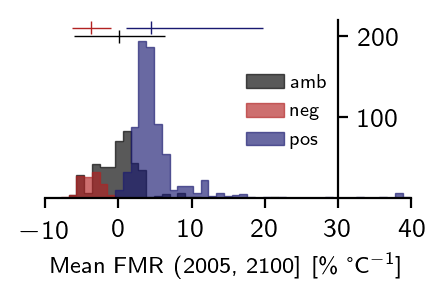

In [86]:
call_plt_params()
fig = plt.figure(1, figsize=(mm2inch(60,30)), frameon=True, dpi=200)
ax = fig.add_subplot(111)
plot_FMR_distributions(axis=ax)

In [59]:
if os.getcwd() != filepath:
    %cd $filepath

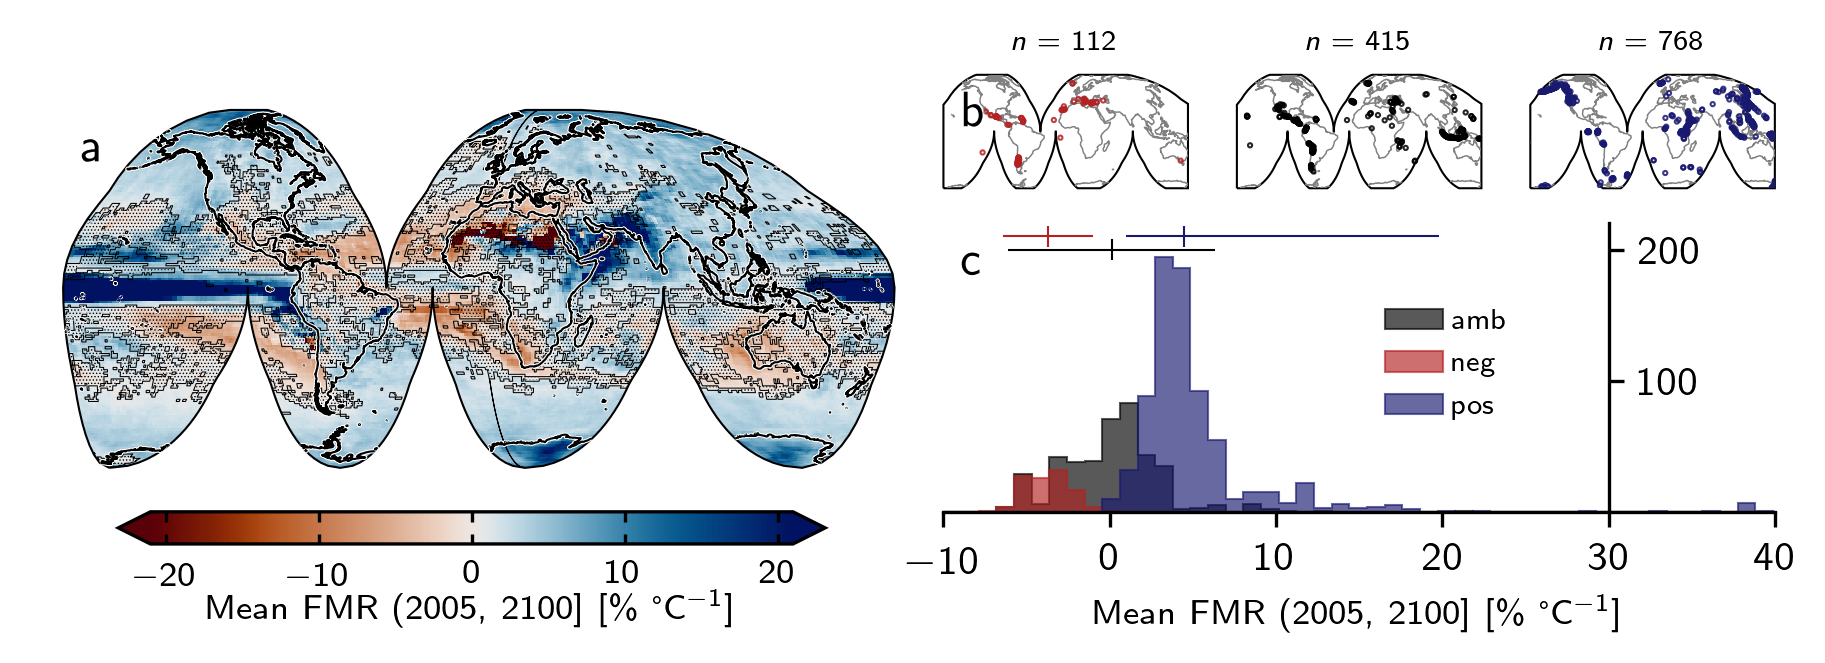

<IPython.core.display.Javascript object>

In [291]:
call_plt_params()
fig = plt.figure(1, figsize=(mm2inch(187,50)), frameon=True, dpi=300)
IGH = ccrs.InterruptedGoodeHomolosine(central_longitude=0)
axs = [plt.subplot2grid((3,6), (0,3), rowspan=1, colspan=1, fig=fig,projection=IGH),
plt.subplot2grid((3,6), (0,4), rowspan=1, colspan=1, fig=fig,projection=IGH),
plt.subplot2grid((3,6), (0,5), rowspan=1, colspan=1, fig=fig,projection=IGH),
plt.subplot2grid((3,6), (0,0), rowspan=3, colspan=3, fig=fig,projection=IGH),
plt.subplot2grid((3,6), (1,3), rowspan=2, colspan=3, fig=fig)]
plot_FMR_distributions(axis=axs[-1])

for ix, lst in enumerate([fmr_neg.name, fmr_amb.name, fmr_pos.name]):
    vset = list(lst)
    set_lons = locations[locations.name.isin(vset)].lons.values
    set_lats = locations[locations.name.isin(vset)].lats.values
    axis = axs[ix]
    axis.coastlines(resolution='110m', color='grey', linewidth=0.35, zorder = 9)
    axis.outline_patch.set_linewidth(0.5)
    axis.outline_patch.set_edgecolor("k")
    axis.scatter(set_lons,set_lats, marker = "o",
                 color = 'None', ec =['firebrick','k','midnightblue'][ix],
                    s = 1, transform = ccrs.PlateCarree(), lw = .5, zorder = 20, alpha = .85)
    axis.set_extent([-180,180,-80,80], ccrs.PlateCarree())
    axis.set_title(r"$n$ = {}".format(len(vset)),fontsize = "x-small")
im = plot_FMR_globe(axis=axs[3])
cax = fig.add_axes([0.11, 0.05, 0.4, 0.5])
cax.axis('off')
cbar = fig.colorbar(im,ax=cax,orientation='horizontal', extend = "both",
                    shrink = 0.8, ticks = [-20, -10, 0, 10, 20], )#pad = .1)
# cbar.ax.set_ylabel(r"Mean FMR (2005, 2100] [\% K$^{-1}$]", rotation=0, fontsize = "small")
cbar.ax.set_ylabel(r"Mean FMR (2005, 2100] [\% {{\textdegree}}C$^{-1}$]", rotation=0, fontsize = "small")

cbar.ax.yaxis.set_label_coords(0.5,-2.6)
cbar.ax.tick_params(labelsize="small", direction = "in", length = 2.5)
cbar.ax.xaxis.set_ticks_position('both')
axs[1].tick_params(labelsize="small")
for ix, axis in enumerate([-2,0,-1]):
    axs[axis].annotate(STRING.ascii_lowercase[ix],**labelArgs, **labelKwargs)
    
    
plt.savefig("climate_figures/fig2.png", bbox_inches="tight")
plt.savefig("climate_figures/fig2.pdf", bbox_inches="tight")
plt.show()
speak("Figure plotted")

#### Figure 2 | Breakdown of mean forced model response.
**a** Global mean forced model response (FMR) calculated from all models. Shaded area indicates those regions where fewer than seven of nine models agreed on the sign of change (26.55 %).

**b** Subaerial volcano geolocations separated according to whether models agree on a decrease in heavy precipitation with increased warming (red: “neg”); the precipitation response is ambiguous due to lack of model agreement (black: “amb”); models agree on an increase in heavy precipitation with increased warming (blue: “pos”). _n_ indicates the number of discrete Holocene-active volcanic systems in each category. 

**c** Histogram of mean FMR for each group of volcanoes (as in __b__). Mean and two standard deviation range are indicated (Methods). 


In [61]:
def plot_FMR_single(volcano, axis, num=9):
    ax = axis
    volcano = volcano
    for i in range(num):
        try:
            gmt, gmt_df = global_mean_temp(fileNameCodes[0][i], method = "max", verbose=False)

            lat, lon = model_lalo(parameter="pr", modelName=fileNameCodes[0][i])
            i_volc, j_volc = volcano_ij(volcano = volcano, lats = lat, lons = lon, verbose = False)
            rx_df, rx = heavy_rainfall(i_volc, j_volc, modelName=fileNameCodes[0][i], method = "max", verbose = False)

            rolling_T = gmt.temp.rolling(30, min_periods =10).mean()
            rolling_rx = rx.rainfall.rolling(30, min_periods=10).mean()
            rT = [x-rolling_T[-80] for x in rolling_T if not math.isnan(x)]
            rR = [((x-rolling_rx[-80])/rolling_rx[-80])*100 for x in rolling_rx if not math.isnan(x)]
            ax.plot(rT, 
             rR, # 65 = len(datset) - window
    # lw = .8, 
                     label = fileNameCodes[0][i],color= inferno(x2clr(i,9)), lw=.5, alpha=.85
        )
    #         rT = [x for x in rolling_T]
    #         rR = [x for x in rolling_rx]

            coef = np.polyfit(rT,rR,1)
            poly1d_fn = np.poly1d(coef) 
            # poly1d_fn is now a function which takes in x and returns an estimate for y

            ax.plot(rT, poly1d_fn(rT), '--k', lw = .5, zorder = np.inf)
        except:
            print("issue with {}".format(fileNameCodes[0][i]))
            continue
# plt.legend()
    ax.axhline(0, lw=.5, color = "grey", zorder = 0)
    ax.axvline(0, lw=.5, color = "grey", zorder = 0)
    ax.set_title(string_rearranger(volcano), fontsize ="x-small")
    ax.set_xlim(-1.5,5.5)
    ax.set_ylim(-17,37)#32
#     ax.xticks([0,2,4])
    ax.minorticks_on()
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.tick_params(axis='both', labelsize="small")
# plt.ylabel("Change in heavy\nprecipitation [\%]")


In [62]:
def plot_FMR_list(volcanoList, axis,region="", num=9,save_gradient=False):
    ax = axis
    vol_list = volcanoList
    gradientList = []
    for i in range(num):
        try:
            gmt, gmt_df = global_mean_temp(fileNameCodes[0][i], method = "max", verbose=False)
            av_rx_df, av_rx = heavy_rainfall_area(vol_list, \
                                         modelName=fileNameCodes[0][i], method = "max", verbose = False)
            rolling_av_rx = av_rx.rainfall.rolling(30, min_periods = 10).mean()

            rolling_T = gmt.temp.rolling(30, min_periods =10).mean()

            rT = [x-rolling_T[-80] for x in rolling_T if not math.isnan(x)]
            raR = [((x-rolling_av_rx[-80])/rolling_av_rx[-80])*100 for x in rolling_av_rx if not math.isnan(x)]
        
            ax.plot(rT, 
             raR, # 65 = len(datset) - window
    # lw = .8, 
                     label = fileNameCodes[0][i],color= inferno(x2clr(i,9)), lw=.5, alpha=.85
        )

            coef = np.polyfit(rT,raR,1)
            poly1d_fn = np.poly1d(coef) 
            # poly1d_fn is now a function which takes in x and returns an estimate for y

            ax.plot(rT, poly1d_fn(rT), '--k', lw = .5, zorder = np.inf)
            if save_gradient == True:
                gradientList.append(coef[0])
        except:
            print("issue with {}".format(fileNameCodes[0][i]))
            continue
# plt.legend()
    ax.axhline(0, lw=.5, color = "grey", zorder = 0)
    ax.axvline(0, lw=.5, color = "grey", zorder = 0)
    ax.set_title(region, fontsize ="x-small")
    ax.set_xlim(-1.5,5.5)
    ax.set_ylim(-17,37)
    plt.xticks([0,2,4])
    ax.minorticks_on()
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)
    ax.tick_params(axis='both', labelsize="small")
    if save_gradient == True:
        return gradientList
# plt.ylabel("Change in heavy\nprecipitation [\%]")


In [88]:
def get_vals(countList, chi2=False):
    from collections import Counter
    from scipy.stats import chisquare
    countr = Counter(sorted(countList))
    for key in range(10):
        if key not in countr:
            countr[key]=0
    if chi2==True:
        print(chisquare(list(countr.values())))
    labels, values = zip(*sorted(countr.items()))
    vals=[x for x in values]
    vals[:0] = [vals[0]]
    vals.append(vals[-1])
    return labels, vals

In [89]:
def plot_count_list(countList, axis,label, xLabel=False):
    ax = axis
    labels, vals = get_vals(countList, chi2=False)
    label_array = np.array(labels)
    width = 1
    indexes=np.arange(-.5,11,1)
    
    ax.step(indexes,vals, color="k", lw=.5, where = "pre")
    ax.fill_between(indexes[-5::],vals[-5::], step="pre", alpha=0.65,lw=.5,
                     color="midnightblue")
    ax.fill_between(indexes[3:-4],vals[3:-4], step="pre", alpha=0.65,lw=.5,
                     color="k")
    ax.fill_between(indexes[0:4],vals[0:4], step="pre", alpha=0.65,lw=.5,
                     color="firebrick")
    ax.set_xlim(-.5,9.5)
    ax.set_ylim(ymin=0, ymax = vals[-1]*1.25)
    ax.set_xticks(label_array-.5 + width * 0.5, labels)
    plt.xticks([0,1,2,3,4,5,6,7,8,9])
    if xLabel == True:
        ax.set_xlabel("Number of models projecting positive FMR", fontsize="small")
    ax.spines["top"].set_visible(False)
    ax.spines['right'].set_bounds(0,vals[-1])
    arrowz = {'arrowstyle': '-', 'lw':.5, 'shrinkA':0,'shrinkB':0}
    ax.annotate('majority', xy=(9.5,vals[-1]*1.2), xytext=(4.5,vals[-1]*1.2), arrowprops=arrowz,
               fontsize="x-small", ha="right", va="center")
    ax.annotate('significant majority', xy=(9.5,vals[-1]*1.05), xytext=(6.5,vals[-1]*1.05), arrowprops=arrowz,
               fontsize="x-small", ha="right", va="center")
    ax.annotate(r"{}; $n$ = {}".format(label,sum(vals[1:-1])),xy=(.05,.5),xycoords="axes fraction", fontsize="small")

In [90]:
def plot_volcano_single(volcano, axis):
    name_volc = volcano
    ax1 = axis
    lat_volc = volcano_set.loc[[name_volc]].lat.values[0]
    lon_volc = volcano_set.loc[[name_volc]].lon.values[0]




    ax1.coastlines(resolution='110m', color='black', linewidth=0.5)
    # ax1.stock_img()

    plt.scatter(lon_volc, lat_volc, color ='r',
                marker = 's', alpha = 1, edgecolor = 'k', s = 25, linewidths = 0.5,
                zorder = 999,transform = ccrs.PlateCarree())
    # ax1.set_extent([-122.25,-121.75,46,46.5])
    offset = 30
    ax1.set_extent([lon_volc-offset/2,lon_volc+offset/2,lat_volc-offset, lat_volc+offset])
    ytk = np.round(lat_volc/10)*10
    xtk = np.round(lon_volc/10)*10
    # ax1.set_xticks([-122], crs=ccrs.PlateCarree())
    ax1.set_xticks([xtk], crs=ccrs.PlateCarree())
    ax1.set_yticks([ytk-10,ytk,ytk+10], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.tick_params(axis='both', which='major', labelsize="xx-small", direction="in")

In [91]:
def get_regional_outlines_(listOfVolcanoes):
    modelFile = netCDF4.MFDataset(list_of_models(parameter="pr", modelName=fileNameCodes[0][0]))
    startString = modelFile.variables["time"].units.split()[2] # Days since XXX date
    start = datetime.strptime(startString, "%Y-%m-%d")
    time = [start+timedelta(int(x)) for x in modelFile.variables["time"][:]]

    lat_vals = modelFile.variables["lat"][:]
    lon_vals = modelFile.variables["lon"][:]
    vol_list  = []
  
    tup_list = volcano_list_ij(volcanoList=listOfVolcanoes, lats=lat_vals, lons=lon_vals)

    row  = [int(np.where(lat_vals == x[0])[0]) for x in tup_list]
    col  = [int(np.where(lon_vals == x[1])[0]) for x in tup_list]
    data = PRCP[row,col]
    coo = sparse.coo_matrix((data, (row, col)), shape=PRCP.shape)
    
#     masked_PRCP = np.where(coo.todense() >0, coo.todense(), np.nan)
    masked_PRCP = np.where(coo.toarray() >0, 1, np.nan)
    
    bool_PRCP = np.where(coo.toarray() >0, 1,0)
    return masked_PRCP, bool_PRCP

In [92]:
def PRCP():
    modelFile = netCDF4.MFDataset(list_of_models(parameter="pr", modelName=fileNameCodes[0][0]))
    PRCP = modelFile.variables["pr"][0,:,:]
    modelFile.close()
    return PRCP
PRCP = PRCP()
    

In [94]:
def return_FMR_list(volcanoList, num=9,save_gradient=True):

    vol_list = volcanoList
    gradientList = []
    for i in range(num):
        try:
            gmt, gmt_df = global_mean_temp(fileNameCodes[0][i], method = "max", verbose=False)
            av_rx_df, av_rx = heavy_rainfall_area(vol_list, \
                                         modelName=fileNameCodes[0][i], method = "max", verbose = False)
            rolling_av_rx = av_rx.rainfall.rolling(30, min_periods = 10).mean()

            rolling_T = gmt.temp.rolling(30, min_periods =10).mean()

            rT = [x-rolling_T[-80] for x in rolling_T if not math.isnan(x)]
            raR = [((x-rolling_av_rx[-80])/rolling_av_rx[-80])*100 for x in rolling_av_rx if not math.isnan(x)]
        

            coef = np.polyfit(rT,raR,1)
            poly1d_fn = np.poly1d(coef) 
            # poly1d_fn is now a function which takes in x and returns an estimate for y

#             ax.plot(rT, poly1d_fn(rT), '--k', lw = .5, zorder = np.inf)
            if save_gradient == True:
                gradientList.append(coef[0])
        except:
            print("issue with {}".format(fileNameCodes[0][i]))
            continue

    if save_gradient == True:
        return gradientList

#### Compiling spatially averaged FMR gradients for all regions and subregions for each model can take upwards of an hour on a 2.8 GHz Quad-Core Intel Core i7 MacBook Pro.

In [95]:
regionalGradients = {}

for ix, region in enumerate(set(volcano_list.Region)):
    vol_list  = []
    subset = volcano_list[volcano_list.Region == region]
    vol_list = list(subset["Volcano_Name"].values)
    gradients = return_FMR_list(vol_list, num=9, save_gradient=True)    
    regionalGradients[region] = gradients
    print('{:02d}% | '.format(int((ix+1)/len(set(volcano_list.Region))*100)), sep=' ', end=' ', flush=True)

time.sleep(.5)
speak("Program complete")

05% |  10% |  15% |  21% |  26% |  31% |  36% |  42% |  47% |  52% |  57% |  63% |  68% |  73% |  78% |  84% |  89% |  94% |  100% |  

<IPython.core.display.Javascript object>

In [96]:
%%time
subregionalGradients = {}

for ix, region in enumerate(set(volcano_list.Subregion)):
    vol_list  = []
    subset = volcano_list[volcano_list.Subregion == region]
    vol_list = list(subset["Volcano_Name"].values)
    gradients = return_FMR_list(vol_list, num=9, save_gradient=True)    
    subregionalGradients[region] = gradients
    print('{:02d}% | '.format(int((ix+1)/len(set(volcano_list.Subregion))*100)), sep=' ', end=' ', flush=True)

time.sleep(.5)
speak("Program complete")

00% |  01% |  02% |  03% |  04% |  05% |  06% |  07% |  08% |  09% |  10% |  11% |  12% |  13% |  14% |  15% |  16% |  17% |  18% |  19% |  20% |  21% |  22% |  23% |  24% |  25% |  26% |  27% |  28% |  29% |  30% |  31% |  32% |  33% |  34% |  35% |  36% |  37% |  38% |  39% |  40% |  41% |  42% |  43% |  44% |  45% |  46% |  47% |  48% |  49% |  50% |  51% |  52% |  53% |  54% |  55% |  56% |  57% |  58% |  59% |  60% |  61% |  62% |  63% |  64% |  65% |  66% |  67% |  68% |  69% |  70% |  71% |  72% |  73% |  74% |  75% |  76% |  77% |  78% |  79% |  80% |  81% |  82% |  83% |  84% |  85% |  86% |  87% |  88% |  89% |  90% |  91% |  92% |  93% |  94% |  95% |  96% |  97% |  98% |  99% |  100% |  

<IPython.core.display.Javascript object>

CPU times: user 56min 23s, sys: 21min 4s, total: 1h 17min 28s
Wall time: 1h 24min 23s


In [97]:
''' Distinguish models that yield positive FMR results'''
region_pos_counts = []
for region in regionalGradients.keys():
    only_pos = [num for num in regionalGradients[region] if num > 0]
    pos_count = len(only_pos) 
    region_pos_counts.append(pos_count)
    
subregion_pos_counts = []
for region in subregionalGradients.keys():
    only_pos = [num for num in subregionalGradients[region] if num > 0]
    pos_count = len(only_pos) 
    subregion_pos_counts.append(pos_count)

In [208]:
def plot_count_list_(axis, xLabel=False):
    ax = axis
    labels, vals = get_vals(countList=region_pos_counts, chi2=False)
    *_, sub_vals = get_vals(countList=subregion_pos_counts, chi2=False)
    label_array = np.array(labels)
    width = 1
    indexes=np.arange(-.5,11,1)
    
    ax.step(indexes,vals, color="k", lw=.5, where = "pre")
    ax.step(indexes,sub_vals, color="k", lw=.5, where = "pre")
    ax.fill_between(indexes,vals, step="pre", alpha=0.65,lw=.5,
                     color="k")
    ax.set_xlim(-.5,9.5)
    ax.set_ylim(ymin=0, ymax = sub_vals[-1]+2)
    ax.set_xticks(label_array-.5 + width * 0.5, labels)
    plt.xticks([0,1,2,3,4,5,6,7,8,9])
    if xLabel == True:
        ax.set_xlabel("Number of models projecting positive FMR", fontsize="small")
    ax.spines["top"].set_visible(False)
    ax.spines['right'].set_bounds(0,sub_vals[-1])
    arrowz = {'arrowstyle': '-', 'lw':.5, 'shrinkA':0,'shrinkB':0}
    ax.annotate('subregional data', xy=(indexes[4]-.5,sub_vals[4]),
                xytext=(0,14),textcoords="offset points", arrowprops=arrowz,
               fontsize="small", ha="center", va="center")
    ax.annotate('regional data', xy=(8.5,5), xytext=(-8,0),textcoords="offset points", arrowprops=arrowz,
               fontsize="small", ha="right", va="center")
    ax.vlines(6.5, 17, 27, color = "grey", lw=.5)
    ax.hlines(27, 6.5, 9.5, color = "grey", lw=.5)
    ax.vlines(4.5, 16, 28, color = "grey", lw=.5, ls="--")
    ax.hlines(28, 4.5, 9.5, color = "grey", lw=.5, ls="--")


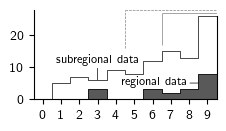

In [209]:
fig = plt.figure(1, mm2inch(60,30), dpi=100)
ax=fig.add_subplot(111)
plot_count_list_(ax)

In [104]:
'''
Sort regions according to the lowest value in the respective FMR distribution
'''
srtd = sorted(regionalGradients.items(), key=lambda e: sorted(e[1])[0])
srtd_ = sorted(subregionalGradients.items(), key=lambda e: sorted(e[1])[0])

[s[0] for s in srtd]

['Melanesia and Australia',
 'Philippines and SE Asia',
 'Kuril Islands',
 'Indonesia',
 'Middle East and Indian Ocean',
 'Japan, Taiwan, Marianas',
 'New Zealand to Fiji',
 'Hawaii and Pacific Ocean',
 'South America',
 'Kamchatka and Mainland Asia',
 'Mediterranean and Western Asia',
 'Africa and Red Sea',
 'West Indies',
 'Iceland and Arctic Ocean',
 'Canada and Western USA',
 'México and Central America',
 'Atlantic Ocean',
 'Alaska',
 'Antarctica']

In [103]:
def gradientKDE(data, bins, density = True):
    ''' Return a kernel density estimate of input data'''
    from scipy import stats
    h,e = np.histogram(data, bins = bins, density=density)
    x = np.linspace(e.min(), e.max(),100)

    kde = stats.gaussian_kde(data)
    return x, kde.pdf(x)

#### Unknown Pleasures plot: pretty but useless

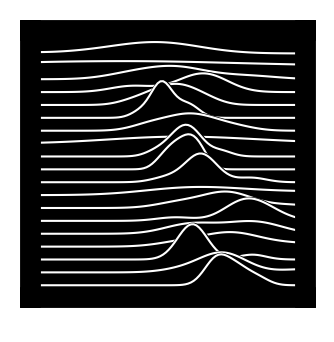

In [183]:
fig = plt.figure(1, figsize=(mm2inch(30,30)), frameon=True, dpi=300)

ax=fig.add_subplot(111)
for i, region in enumerate([s[0] for s in srtd]):
    x, kdex = gradientKDE(data = regionalGradients[region],
                         bins = np.linspace(-12,12,24),
                          density=True)
    ax.fill_between(x,y1= kdex-.1*i,y2=-.1*i, color="k",
                    zorder=(2*i)-1, alpha = 1.)
    ax.plot(x, kdex-.1*i, lw=.5,color="w", zorder=2*i)
ax.set_xlim([-12,12])
ax.set_facecolor("k")
ax.set_xticklabels([])
ax.set_xticks([])
ax.tick_params(labelbottom=False)
ax.tick_params(labelleft=False) 
ax.tick_params(left= False)
[ax.spines[k].set_linewidth(5) for k in ax.spines.keys()]
[ax.spines[k].set_zorder(np.inf) for k in ax.spines.keys()]
plt.show()

In [226]:
# def plot_south_pole(axis):
#     import matplotlib.path as mpath
#     import cartopy.feature as cfeature
#     ax1 = axis
#     ax1.coastlines(resolution='110m', color='k', linewidth=0.25, zorder = 9)
#     regionList = list(set(volcano_list.Region))
#     for ix, region in enumerate(regionList):
#         try:
#             subset = volcano_list[volcano_list.Region == region]
#         except:
#             subset = volcano_list[volcano_list.Subregion == region]
#         vol_list = list(subset["Volcano_Name"].values)
#         mask_A, bool_A = get_regional_outlines_(vol_list)
#         cmap = matplotlib.colors.ListedColormap([roma_map(x2clr(ix,19)),'None'])
#         ax1.imshow(mask_A, cmap=cmap,alpha = .85, transform = ccrs.PlateCarree(), zorder=np.inf)
#         ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

#     ax1.add_feature(cfeature.LAND, color ="gainsboro", zorder=1)
#     ax1.add_feature(cfeature.OCEAN, color ="k", zorder=1)

#     gl = ax1.gridlines(draw_labels=False, xlocs=None, ylocs=None,
#                       linewidth=.1, color='black', 
#     alpha=0.25, linestyle='--', zorder = 0)
#     # Compute a circle in axes coordinates, which we can use as a boundary
#     # for the map. We can pan/zoom as much as we like - the boundary will be
#     # permanently circular.
#     theta = np.linspace(0, 2*np.pi, 100)
#     center, radius = [0.5, 0.5], 0.56
#     verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#     circle = mpath.Path(verts * radius + center)

#     ax1.set_boundary(circle, transform=ax1.transAxes)
#     gl.n_steps = 90 ## adjust gridline resolution
#     ax1.outline_patch.set_linewidth(.25)

In [285]:
def plot_north_pole(axis):
    import matplotlib.path as mpath
    import cartopy.feature as cfeature
    ax1 = axis
    resol = '50m'
    ax1.coastlines(resolution=resol, color='k', linewidth=0.2, zorder = 9)
    regionList = list(set(volcano_list.Region))
    
    land = cfeature.NaturalEarthFeature('physical', 'land', \
        scale=resol, edgecolor='none', facecolor="gainsboro")
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', \
    scale=resol, edgecolor='none', facecolor="dimgrey")
    
    for ix, region in enumerate(regionList):
        try:
            subset = volcano_list[volcano_list.Region == region]
        except:
            subset = volcano_list[volcano_list.Subregion == region]
        vol_list = list(subset["Volcano_Name"].values)
        mask_A, bool_A = get_regional_outlines_(vol_list)
        cmap = matplotlib.colors.ListedColormap([roma_map(x2clr(ix,19)),'None'])
        ax1.imshow(mask_A, cmap=cmap,alpha = .95, transform = ccrs.PlateCarree(), zorder=np.inf)
        ax1.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())
    ax1.add_feature(land, zorder=3)
    ax1.add_feature(ocean, zorder=1)
#     ax1.add_feature(cfeature.LAND, color ="gainsboro", zorder=3)
#     ax1.add_feature(cfeature.OCEAN, color ="darkgrey", zorder=1)
    gl = ax1.gridlines(draw_labels=False, xlocs=None, ylocs=None,
                      linewidth=.25, color='black', 
    alpha=0.5, linestyle='--', zorder = 2)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.56
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax1.set_boundary(circle, transform=ax1.transAxes)
    gl.n_steps = 90 ## adjust gridline resolution
    ax1.outline_patch.set_linewidth(.5)
    ax1.outline_patch.set_zorder(np.inf)

In [272]:
# def plot_north_pole_(axis):
#     import matplotlib.path as mpath
#     import cartopy.feature as cfeature
#     ax1 = axis
#     resol = '50m'
#     ax1.coastlines(resolution=resol, color='k', linewidth=0.2, zorder = 9)
#     regionList = list(set(volcano_list.Region))
    
#     land = cfeature.NaturalEarthFeature('physical', 'land', \
#         scale=resol, edgecolor='none', facecolor="gainsboro")
#     ocean = cfeature.NaturalEarthFeature('physical', 'ocean', \
#     scale=resol, edgecolor='none', facecolor="dimgrey")
#     for ix, region in enumerate(regionList):
#         try:
#             subset = volcano_list[volcano_list.Region == region]
#         except:
#             subset = volcano_list[volcano_list.Subregion == region]
#         vol_list = list(subset["Volcano_Name"].values)
#         mask_A, bool_A = get_regional_outlines_(vol_list)
#         cmap = matplotlib.colors.ListedColormap([roma_map(x2clr(ix,19)),'None'])
#         ax1.imshow(mask_A, cmap=cmap,alpha = .95, transform = ccrs.PlateCarree(), zorder=np.inf)
#     ax1.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

#     ax1.add_feature(land, zorder=3)
#     ax1.add_feature(ocean, zorder=1)
# #     ax1.add_feature(cfeature.LAND, color ="gainsboro", zorder=3)
# #     ax1.add_feature(cfeature.OCEAN, color ="dimgrey", zorder=1)
#     gl = ax1.gridlines(draw_labels=False, xlocs=None, ylocs=None,
#                       linewidth=.25, color='black', 
#     alpha=1, linestyle='--', zorder = 2)
#     # Compute a circle in axes coordinates, which we can use as a boundary
#     # for the map. We can pan/zoom as much as we like - the boundary will be
#     # permanently circular.
#     theta = np.linspace(0, 2*np.pi, 100)
#     center, radius = [0.5, 0.5], 0.56
#     verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#     circle = mpath.Path(verts * radius + center)

#     ax1.set_boundary(circle, transform=ax1.transAxes)
#     gl.n_steps = 90 ## adjust gridline resolution
#     ax1.outline_patch.set_linewidth(.5)
#     ax1.outline_patch.set_zorder(np.inf)

In [292]:
def plot_south_pole(axis):
    import matplotlib.path as mpath
    import cartopy.feature as cfeature
    resol = '50m'
    ax1 = axis
    ax1.coastlines(resolution=resol, color="k", linewidth=0.2, zorder = 9)
    regionList = list(set(volcano_list.Region))
    land = cfeature.NaturalEarthFeature('physical', 'land', \
        scale=resol, edgecolor='none', facecolor="gainsboro")
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', \
    scale=resol, edgecolor='none', facecolor="dimgrey")
    for ix, region in enumerate(regionList):
        try:
            subset = volcano_list[volcano_list.Region == region]
        except:
            subset = volcano_list[volcano_list.Subregion == region]
        vol_list = list(subset["Volcano_Name"].values)
        mask_A, bool_A = get_regional_outlines_(vol_list)
        cmap = matplotlib.colors.ListedColormap([roma_map(x2clr(ix,19)),'None'])
        ax1.imshow(mask_A, cmap=cmap,alpha = .95, transform = ccrs.PlateCarree(), zorder=np.inf)
        ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

#     ax1.add_feature(cfeature.LAND, color ="gainsboro", zorder=1)
#     ax1.add_feature(cfeature.OCEAN, color ="k", zorder=1)
    ax1.add_feature(land, zorder=3)
    ax1.add_feature(ocean, zorder=1)
    gl = ax1.gridlines(draw_labels=False, xlocs=None, ylocs=None,
                      linewidth=.25, color='k', 
    alpha=.5, linestyle='--', zorder = 2)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.56
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax1.set_boundary(circle, transform=ax1.transAxes)
    gl.n_steps = 90 ## adjust gridline resolution
    ax1.outline_patch.set_linewidth(.5)
    ax1.outline_patch.set_zorder(np.inf)

In [266]:
# def plot_south_pole_(axis):
#     import matplotlib.path as mpath
#     import cartopy.feature as cfeature
#     resol = '50m'
#     ax1 = axis
#     ax1.coastlines(resolution=resol, color="gainsboro", linewidth=0.2, zorder = 9)
#     regionList = list(set(volcano_list.Region))
#     land = cfeature.NaturalEarthFeature('physical', 'land', \
#         scale=resol, edgecolor='none', facecolor="w")#gainsboro")
#     ocean = cfeature.NaturalEarthFeature('physical', 'ocean', \
#     scale=resol, edgecolor='none', facecolor="k")
#     for ix, region in enumerate(regionList):
#         try:
#             subset = volcano_list[volcano_list.Region == region]
#         except:
#             subset = volcano_list[volcano_list.Subregion == region]
#         vol_list = list(subset["Volcano_Name"].values)
#         mask_A, bool_A = get_regional_outlines_(vol_list)
#         cmap = matplotlib.colors.ListedColormap([roma_map(x2clr(ix,19)),'None'])
#         ax1.imshow(mask_A, cmap=cmap,alpha = .85, transform = ccrs.PlateCarree(), zorder=np.inf)
#         ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

# #     ax1.add_feature(cfeature.LAND, color ="gainsboro", zorder=1)
# #     ax1.add_feature(cfeature.OCEAN, color ="k", zorder=1)
#     ax1.add_feature(land, zorder=3)
#     ax1.add_feature(ocean, zorder=1)
#     gl = ax1.gridlines(draw_labels=False, xlocs=None, ylocs=None,
#                       linewidth=.25, color='gainsboro', 
#     alpha=0.25, linestyle='--', zorder = 2)
#     # Compute a circle in axes coordinates, which we can use as a boundary
#     # for the map. We can pan/zoom as much as we like - the boundary will be
#     # permanently circular.
#     theta = np.linspace(0, 2*np.pi, 100)
#     center, radius = [0.5, 0.5], 0.56
#     verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#     circle = mpath.Path(verts * radius + center)

#     ax1.set_boundary(circle, transform=ax1.transAxes)
#     gl.n_steps = 90 ## adjust gridline resolution
#     ax1.outline_patch.set_linewidth(.25)
#     ax1.outline_patch.set_zorder(np.inf)

In [233]:
# def plot_region_map(axis, regionList = False):
#     ax1 = axis
#     ax1.coastlines(resolution='110m', color='grey', linewidth=0.25, zorder = 9)
#     if regionList != False:
#         regionList = regionList
#     else:
#         regionList = list(set(volcano_list.Region))
#     for ix, region in enumerate(regionList):
#         try:
#             subset = volcano_list[volcano_list.Region == region]
#         except:
#             subset = volcano_list[volcano_list.Subregion == region]
#         vol_list = list(subset["Volcano_Name"].values)
#         mask_A, bool_A = get_regional_outlines_(vol_list)
#         cmap = matplotlib.colors.ListedColormap([roma_map(x2clr(ix,19)),'None'])
#         ax1.imshow(mask_A, cmap=cmap, transform = ccrs.PlateCarree(), zorder=999)#np.inf)
#     ax1.set_extent([-180,180,-65,65], ccrs.PlateCarree())
#     ax1.add_feature(cfeature.LAND, color ="gainsboro", zorder=1)
#     gl = ax1.gridlines(draw_labels=False, xlocs=None, ylocs=None,
#                           linewidth=.1, color='black', 
#     alpha=0.25, linestyle='--', zorder = 0)
#     ax1.outline_patch.set_linewidth(.25)

In [286]:
def plot_region_map(axis, regionList = False):
    ax1 = axis
    
    resol = '50m'
    ax1 = axis
    ax1.coastlines(resolution=resol, color="k", linewidth=0.2, zorder = 9)
    regionList = list(set(volcano_list.Region))
    land = cfeature.NaturalEarthFeature('physical', 'land', \
        scale=resol, edgecolor='none', facecolor="gainsboro")
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', \
    scale=resol, edgecolor='none', facecolor="dimgrey")
    if regionList != False:
        regionList = regionList
    else:
        regionList = list(set(volcano_list.Region))
    for ix, region in enumerate(regionList):
        try:
            subset = volcano_list[volcano_list.Region == region]
        except:
            subset = volcano_list[volcano_list.Subregion == region]
        vol_list = list(subset["Volcano_Name"].values)
        mask_A, bool_A = get_regional_outlines_(vol_list)
        cmap = matplotlib.colors.ListedColormap([roma_map(x2clr(ix,19)),'None'])
        ax1.imshow(mask_A, cmap=cmap, transform = ccrs.PlateCarree(), zorder=999)#np.inf)
    ax1.set_extent([-180,180,-65,65], ccrs.PlateCarree())
#     ax1.add_feature(cfeature.LAND, color ="gainsboro", zorder=1)
    ax1.add_feature(land, zorder=3)
    ax1.add_feature(ocean, zorder=1)
    gl = ax1.gridlines(draw_labels=False, xlocs=None, ylocs=None,
                          linewidth=.25, color='black', 
    alpha=0.5, linestyle='--', zorder = 2)
    ax1.outline_patch.set_linewidth(.5)
    ax1.outline_patch.set_zorder(np.inf)

<IPython.core.display.Javascript object>

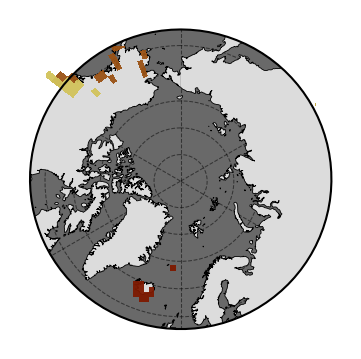

In [283]:
fig = plt.figure(1, figsize=(mm2inch(30,30)), frameon=True, dpi=300)
ax = fig.add_subplot(111,projection=ccrs.NorthPolarStereo())
plot_north_pole(axis = ax)
speak("Plotted")

<IPython.core.display.Javascript object>

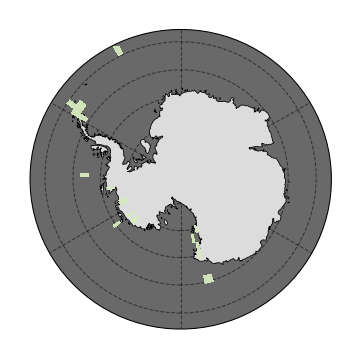

In [284]:
fig = plt.figure(1, figsize=(mm2inch(30,30)), frameon=True, dpi=300)
ax = fig.add_subplot(111,projection=ccrs.SouthPolarStereo())
plot_south_pole(axis = ax)
speak("Plotted")

In [296]:
def shuffle_axis(axis, offset=[0,0,1,1]):
    axis = axis
    pos1 = axis.get_position() # get the original position 
    pos2 = [pos1.x0 + offset[0], pos1.y0 + offset[1],\
                 pos1.width * offset[2], pos1.height * offset[3]] 
    axis.set_position(pos2) # set a new position

<IPython.core.display.Javascript object>

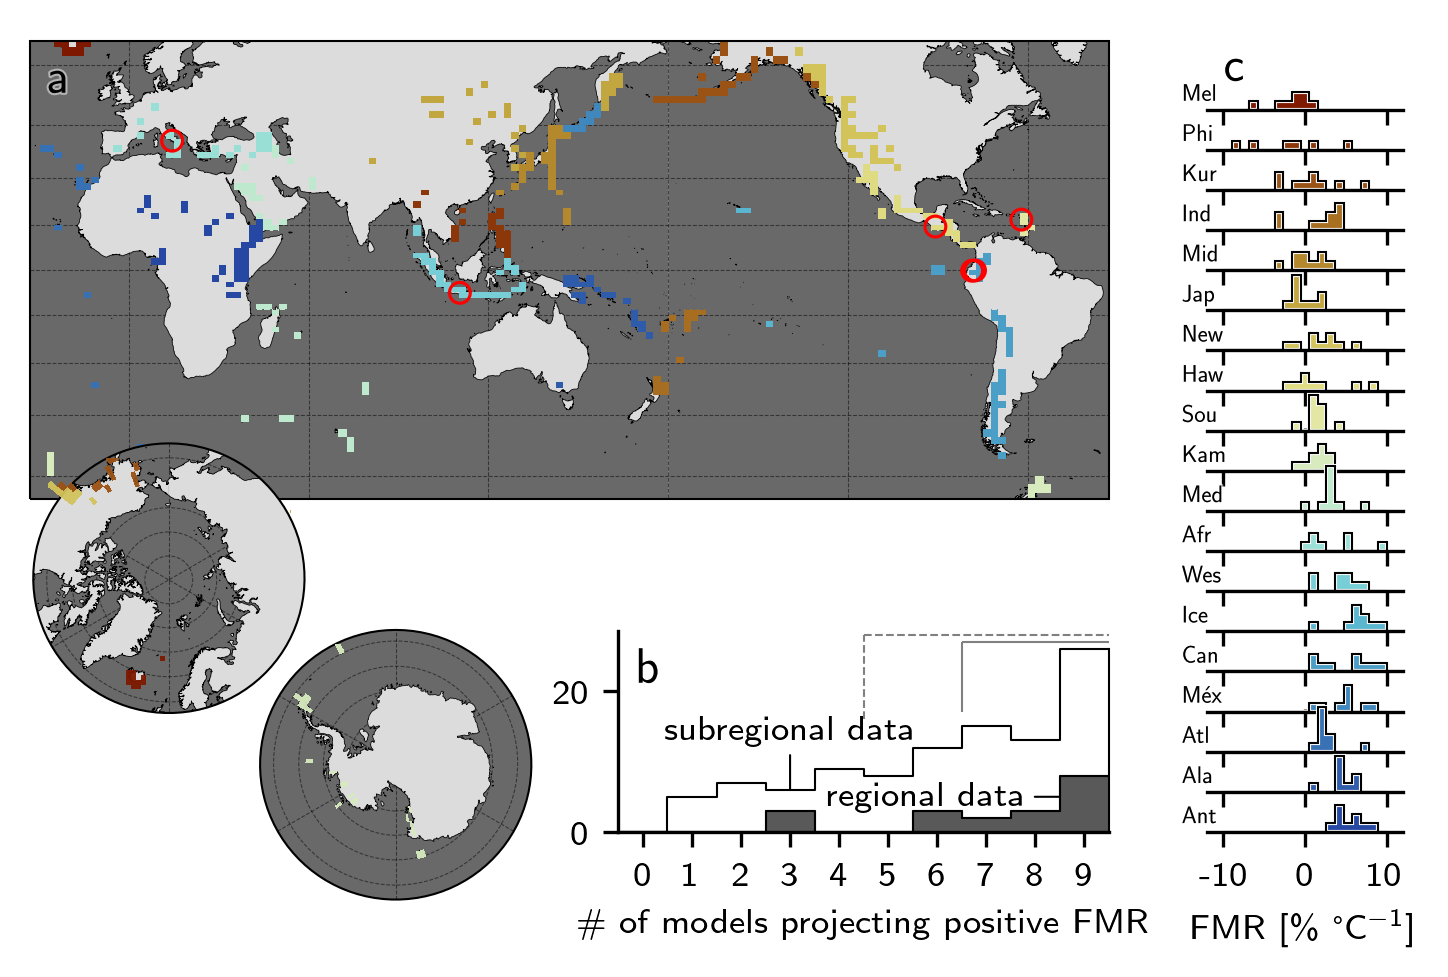

In [300]:
numAxes = 19
fig = plt.figure(1, figsize=(mm2inch(150,90)), frameon=True, dpi=300)
gs = plt.GridSpec(numAxes, 5, figure = fig, wspace = 0.5, hspace = -.5)
axs = []
for n in range(numAxes):
    axs.append(fig.add_subplot((gs[n,-1])))
axs.append(fig.add_subplot((gs[0:-8,0:-1]),projection=ccrs.Miller(central_longitude=147)))
# axs.append(fig.add_subplot((gs[-7:-3,0:1]),projection=ccrs.NorthPolarStereo()))
# axs.append(fig.add_subplot((gs[-7:-3,1:2]),projection=ccrs.SouthPolarStereo()))
axs.append(fig.add_subplot((gs[-7:-2,0:2]),projection=ccrs.NorthPolarStereo()))
axs.append(fig.add_subplot((gs[-5::,0:3]),projection=ccrs.SouthPolarStereo()))
axs.append(fig.add_subplot((gs[-4:,0:2])))
axs.append(fig.add_subplot((gs[-4:,2:4])))
# plot_count_list(countList = region_pos_counts, axis=axs[-2], label = "Region")
plot_count_list_(axis=axs[-1])
axs[-1].set_xticks(np.arange(0,10,1))
# plot_count_list(countList = subregion_pos_counts, axis=axs[-1], label = "Subregion")

    
for i, region in enumerate([s[0] for s in srtd]):#regionalGradients.keys()):
    axs[i].hist(regionalGradients[region], bins = np.linspace(-10,10, 20),
                            density = False, histtype = "stepfilled", ec ="w",fc=roma_map(x2clr(i,19)),
                alpha= 1,lw = 1.)
    axs[i].hist(regionalGradients[region], bins = np.linspace(-10,10, 20),
                            density = False, histtype = "step", lw=.5,ec ="k")#roma_map(x2clr(i,19)))
#     x, kdex = gradientKDE(data = regionalGradients[region],
#                          bins = np.linspace(-12,12,24),
#                           density=True)

#     axs[i].plot(x, kdex*9, lw=.5,color="k", zorder =20)
    
#     x, kdex = gradientKDE(data = regionalGradients[region],
#                          bins = np.linspace(-12,12,24),
#                           density=True)
#     axs[i].plot(x, kdex, lw=1.,color="w")
#     axs[i].plot(x, kdex, lw=.5,color="k")
#     axs[i].fill_between(x, kdex, color=roma_map(x2clr(i,19)))
    
    axs[i].set_ylim([0,9])#.5
    axs[i].set_xlim([-12,12])
    axs[i].set_facecolor("None")
    axs[i].set_xticklabels([])
    axs[i].set_xticks([-10,0,10])
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["left"].set_visible(False)
    axs[i].tick_params(labelbottom=False)
    axs[i].tick_params(labelleft=False) 
    axs[i].tick_params(left= False)
    axs[i].vlines(0,0,0.25, lw=.8, color="k", zorder = 0)
    axs[i].annotate(region[0:3], xy = (-11,1), xytext=(-8,0),
                    textcoords = "offset points",
                    xycoords="data",
                    fontsize = "xx-small", path_effects = buffer)
# axs[18].set_xlabel("Slope of FMR", fontsize = "small")
axs[18].set_xlabel(r"FMR [\% {{\textdegree}}C$^{-1}$]", fontsize = "small")


axs[18].tick_params(labelbottom=True)
axs[18].set_xticklabels([-10,0,10])

for i in [18,-2,-1]:
    axs[i].tick_params(axis='both', labelsize="small")

plot_region_map(axis = axs[19])    
plot_north_pole(axis = axs[20])
plot_south_pole(axis = axs[21])
axs[-1].set_ylim(ymax=28.5)
axs[-1].spines["right"].set_linewidth(.5)
axs[-1].set_xlabel("\# of models projecting positive FMR", fontsize="small")
axs[-2].axis("Off")
for ix,i in enumerate([19,-1,0]):
#     for num, label in enumerate(STRING.ascii_lowercase[4:16]):
    axs[i].annotate(STRING.ascii_lowercase[ix], xy=(0, 1),xytext=(4, -4),
                      xycoords='axes fraction',textcoords='offset points',
    color='k',fontsize = 12, path_effects = buffer,ha='left', va='top', zorder = np.inf)
axs[20].set_zorder(np.inf)

for name_volc in ["Guagua Pichincha","Reventador",\
                  "Soufriere Hills", "Vesuvius","Merapi",\
                 "Fuego"]:

    lat_volc = volcano_set.loc[[name_volc]].lat.values[0]
    lon_volc = volcano_set.loc[[name_volc]].lon.values[0]

    axs[19].scatter(lon_volc, lat_volc, color ='None',
                marker = 'o', alpha = 1, edgecolor = 'r', s = 25, linewidths = 0.75,
                zorder = np.inf,transform = ccrs.PlateCarree())

# Shuffle Polar axis a little    
# pos1 = axs[20].get_position() # get the original position 
# pos2 = [pos1.x0 - 0.1, pos1.y0,  pos1.width, pos1.height] 
# axs[20].set_position(pos2) # set a new position
shuffle_axis(axis=axs[20], offset=[-.06,.05,1,1])
shuffle_axis(axis=axs[21], offset=[-.015,-.05,1,1])


plt.savefig("climate_figures/fig3_.png", bbox_inches="tight")
plt.savefig("climate_figures/fig3_.pdf", bbox_inches="tight")
speak("Figure plotted")

#### Figure 3 | Regional and sub-regional spatial averages.
**a** Map indicating the noncontiguous spatial extent over which regional data are averaged. Circle markers indicate individual volcanoes shown in Figure 4. [Inset] polar regions. 


**b** Bar chart of the number of regions and subregions where x number of models project a spatially averaged forced model response (FMR) > 0 (i.e. a concomitant increase in heavy precipitation and global mean temperature). Dashed bracket indicates the majority of models, solid bracket indicates 7 or more out of 9 models. 

**c** Inter-model distributions of calculated FMR for each region. 

<IPython.core.display.Javascript object>

CPU times: user 6min 29s, sys: 2min 31s, total: 9min 1s
Wall time: 9min 54s


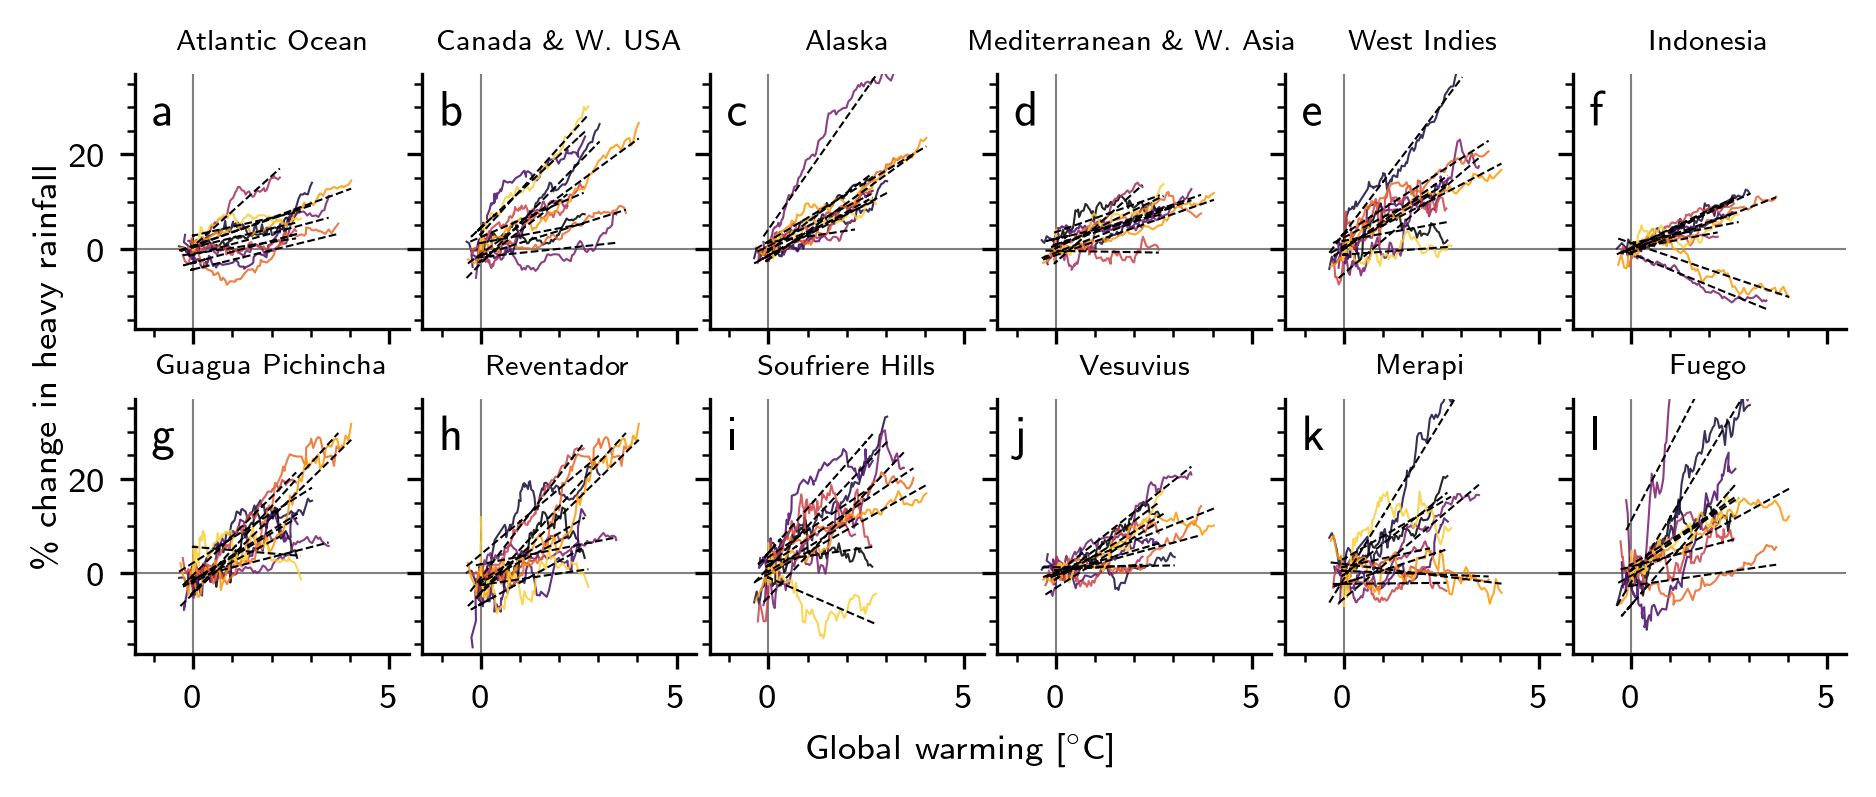

In [298]:
%%time
call_plt_params()
fig = plt.figure(1, figsize=(mm2inch(187,65)), frameon=True, dpi=300)

gs = plt.GridSpec(4, 6, figure=fig, wspace=.05, hspace=.75
                 )

axs = [fig.add_subplot((gs[0:2,0])),
       fig.add_subplot((gs[0:2,1])),
       fig.add_subplot((gs[0:2,2])),
       fig.add_subplot((gs[0:2,3])),
       fig.add_subplot((gs[0:2,4])),
       fig.add_subplot((gs[0:2,5])),
       
       fig.add_subplot((gs[2:4,0])),
       fig.add_subplot((gs[2:4,1])),
       fig.add_subplot((gs[2:4,2])),
       fig.add_subplot((gs[2:4,3])),
       fig.add_subplot((gs[2:4,4])),
       fig.add_subplot((gs[2:4,5])),

      ]
for num, label in enumerate(STRING.ascii_lowercase[0:12]):
    axs[num].annotate(label, **labelArgs,**labelKwargs)
vol_list  = []
for ix, region in enumerate(['Atlantic Ocean','Canada and Western USA',\
                             'Alaska', "Mediterranean and Western Asia",\
                             'West Indies', 'Indonesia']): #Honshu
    subset = volcano_list[volcano_list.Region == region]
    vol_list = list(subset["Volcano_Name"].values)
    plot_FMR_list(vol_list, axis=axs[ix], region=region,num=9)
    os.system("printf '\7'")
axs[1].set_title("Canada \& W. USA ", fontsize ="x-small")
axs[3].set_title("Mediterranean \& W. Asia ", fontsize ="x-small")

    
for ix, volc in enumerate(["Guagua Pichincha","Reventador",\
                          "Soufriere Hills","Vesuvius",\
                          "Merapi", "Fuego"]):
    plot_FMR_single(volcano=volc, axis = axs[ix+6])
    os.system("printf '\7'")
for i in range(12):
    if not i in [0,6]:
        axs[i].set_yticklabels([])
    if i <6:
        axs[i].set_xticklabels([])
# for i in [6,7,8,9,10,11]:
#     axs[i].set_xlabel(r"Global warming [$^{\circ}$C]", fontsize="small")
#      plt.ylabel(r"\% change in heavy rainfall")
#     plt.xlabel(r"Global warming [$^{\circ}$C]")
axs[-1].set_xticks([0,5])
fig.text(0.085,.5,"\% change in heavy rainfall",  rotation = 90, fontsize = "small", va = "center", ha = "center")
fig.text(0.5,0,r"Global warming [$^{\circ}$C]",  fontsize = "small", va = "center", ha = "center")
plt.savefig("climate_figures/fig4.png", bbox_inches="tight")
plt.savefig("climate_figures/fig4.pdf", bbox_inches="tight")
speak("figure plotted")

#### Figure 4 | Forced model responses at different spatial scales.
**a-f** Percent change in modeled heavy rainfall per degree of global warming. Data are shown as a 30-yr rolling mean, normalised to January 2021. Dashed black lines are linear regression of response for each model. Data are areal averages (see Figure 3 for areal extent of each region).


**g-l** As __a–f__, for individual volcanic systems. Data correspond to the bounding pixel for each model (see Methods). Volcano locations are shown in Figure 3.



### Textual analysis of Smithsonian Institution Global Volcanism Program bulletin reports
https://volcano.si.edu/gvp_votw.cfm

In [ ]:
cd data

In [ ]:
'''
Generate 'rain_url.txt' file with list of urls required for data download.

This is to check GVP pages for mentions of "lahar" 
'''
prefix = 'https://volcano.si.edu/volcano.cfm?vn='
string_list = [volcano_list[volcano_list.Volcano_Name == volcano].\
Volcano_Number.values[0] for volcano in list(set(locations.name))]#set(hr_mentions)-set(lahar_mentions))]#list(set(locations.name))]#, last=dt.date(2018,12,18)))

with open("rain_url.txt", "w") as output:
    for line in list([ prefix+str(x)+"\n" for x in string_list ]):
        output.write(str(line))
!wget -nv -i rain_url.txt -nc -c 
print('GVP pages retrieved')

In [ ]:
datafile = 'rain_url.txt'
f = open(datafile)
f.seek(0)
fileIDs = f.readlines()
f.close()
fileIDs = [line.rstrip('\n') for line in fileIDs]
fileIDs = [line.lstrip('https://volcano.si.edu/') for line in fileIDs]

In [ ]:
bulletin_report_dict = {}

literals = ["lahar", "heavy rain", "rainfall-triggered","rainfall triggered",\
            "rainfall-induced","rainfall induced", "extreme rain"]
for string in literals:
    lines = []
    mentions = []
    searched_string = string
    for file in fileIDs:
        filename = glob.glob('*{}'.format(file))
        with open(filename[0]) as f:
            line = f.readline()
            while line:
                if searched_string in line.lower():
                    lines.append(volcano_list[volcano_list.Volcano_Number\
                 == int(filename[0][-6::])].Volcano_Name.values[0])
                    lines.append(line)
                    mentions.append(volcano_list[volcano_list.Volcano_Number\
                 == int(filename[0][-6::])].Volcano_Name.values[0])


                line = f.readline()
    bulletin_report_dict["{}".format(string)] = mentions
    print("{} : {} entries".format(string, len(mentions)))


In [ ]:
'''Number of unique volcanoes flagged by string'''
for key in bulletin_report_dict.keys():
    print("{} : {}".format(key, len(set(bulletin_report_dict[key]))))

In [ ]:
''' Check for any volcanic systems that aren't included in the 'lahar' set '''
uniqueValues = {}
for key in bulletin_report_dict.keys():
    if not key == 'lahar':
        temporarySet = set(bulletin_report_dict[key])
        uniqueValues[key] = list(temporarySet - set(bulletin_report_dict['lahar']))
        

In [ ]:
[x for x in uniqueValues.values()]

In [ ]:
''' Reports can be read'''
for string in ["rainfall triggered"]: ## modify literal
    lines = []
    searched_string = string
    for file in fileIDs:
        filename = glob.glob('*{}'.format(file))
        with open(filename[0]) as f:
            line = f.readline()
            while line:
                if searched_string in line.lower():
                    lines.append(volcano_list[volcano_list.Volcano_Number\
                 == int(filename[0][-6::])].Volcano_Name.values[0])
                    lines.append(line)
                    try:
                        chunk1 = lines[-1][0:lines[-1].find(string)]
                        chunk2 = string
                        chunk3 = lines[-1][lines[-1].find(string)+len(string)::]
                        ''' Highlight search strings'''
                        print("{}\033[42;33m{}\033[m{}".format(chunk1, chunk2, chunk3))
                    except:
                        print(line)

                line = f.readline()
 